<a href="https://colab.research.google.com/github/echen4628/Biods276Final/blob/main/Main_Code_for_CheXagent%2BBiomedParse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up Environment

In [ ]:
!git clone https://github.com/microsoft/BiomedParse.git


Cloning into 'BiomedParse'...
remote: Enumerating objects: 1552, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 1552 (delta 83), reused 132 (delta 72), pack-reused 1401 (from 1)
Receiving objects: 100% (1552/1552), 651.58 MiB | 41.74 MiB/s, done.
Resolving deltas: 100% (454/454), done.
Updating files: 100% (582/582), done.
Filtering content: 100% (45/45), 69.68 MiB | 44.43 MiB/s, done.


In [ ]:
cd BiomedParse

/content/BiomedParse


In [ ]:
!pip install -r assets/requirements/requirements.txt

  Cloning https://github.com/MaureenZOU/detectron2-xyz.git to /tmp/pip-req-build-dfj6mwg9
  Running command git clone --filter=blob:none --quiet https://github.com/MaureenZOU/detectron2-xyz.git /tmp/pip-req-build-dfj6mwg9
  Resolved https://github.com/MaureenZOU/detectron2-xyz.git to commit 42121d75e10d9f858f3a91b6a39f5722c02868f0
  Preparing metadata (setup.py) ... done


In [ ]:
import json

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5


Upload the images and reports into the `BiomedParse` folder.

## Set Up BiomedParse

In [ ]:
from PIL import Image, ImageEnhance, ImageOps
import torch
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image
import numpy as np

class Image_Selector:
  def __init__(self, image_path):
    '''
    This is a wrapper to use BiomedParse to extract parts of an image.
    '''
    # this function copies the setup from https://huggingface.co/microsoft/BiomedParse
    # Build model config
    opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
    opt = init_distributed(opt)

    # Load model from pretrained weights
    pretrained_pth = 'hf_hub:microsoft/BiomedParse'

    self.model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
    with torch.no_grad():
        self.model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

    if image_path:
      self.upload_image(image_path)

  def upload_image(self, image_path):
    self.image_path = image_path
    self.image = Image.open(self.image_path, formats=['png'])
    self.image = self.image.convert('RGB')

  def colorize_image(self, black_recolor="blue", white_recolor="orange"):
    '''
    Colors the image for easier visualization. Not used for inference
    '''
    image_colorized = ImageOps.colorize(ImageOps.grayscale(self.image), black=black_recolor, white=white_recolor)
    return image_colorized

  def infer_image(self, prompts):
    '''
    prompts: list of strings

    For every prompt not equal to "None," use the prompt and BiomedParse to segment the image.

    returns: list of either masks if the prompt is not None or None.
    '''
    outputs = [None]*len(prompts)
    cleaned_prompts = []
    for i, prompt in enumerate(prompts):
      if prompt is None:
        outputs[i] = self.image.copy()
      else:
        cleaned_prompts.append(prompt)

    if cleaned_prompts:
      pred_mask = interactive_infer_image(self.model, self.image, cleaned_prompts)
    else:
      pred_mask = []

    output_i = 0
    pred_mask_i = 0

    while output_i < len(prompts):
      if outputs[output_i] is None:
        outputs[output_i] = pred_mask[pred_mask_i]
        pred_mask_i += 1
        output_i += 1
      else:
        output_i += 1

    return outputs

  def zoom_in_image(self, pred, size_threshold=0):
    '''
    pred: any 2D array representing a segmentation mask
    size_threshold: an int to ensure the zoomed in image has at least this many
                    pixels.

    Scans through the entire segmentatin mask and returns a minimal bounding box for each
      continuous chunks of pixels and their sizes.
    '''
    from collections import deque

    visited = set()
    queue = deque()

    all_bounding_boxes = []
    zoomed_images = []

    def bfs(i,j):
      queue.append((i,j))
      min_x, min_y, max_x, max_y = float('inf'), float('inf'), float('-inf'), float('-inf')
      size = 0
      while queue:
        curr_x, curr_y = queue.popleft()
        visited.add((curr_x, curr_y))
        if pred[curr_y, curr_x]:
          size += 1
          min_x = min(min_x, curr_x)
          max_x = max(max_x, curr_x)
          min_y = min(min_y, curr_y)
          max_y = max(max_y, curr_y)
          for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            new_x, new_y = curr_x + dx, curr_y + dy
            if 0 <= new_x < pred.shape[1] and \
              0 <= new_y < pred.shape[0] and \
              (new_x, new_y) not in visited:
              queue.append((new_x, new_y))
              visited.add((new_x, new_y))
      return [min_x, min_y, max_x, max_y], size

    for y in range(pred.shape[0]):
      for x in range(pred.shape[1]):
        if (x,y) not in visited and pred[y,x]:
          new_box, new_size = bfs(x,y)
          if new_size >= size_threshold:
            all_bounding_boxes.append(new_box)

    for box in all_bounding_boxes:
      zoomed_images.append(self.image.crop(box))
    return zoomed_images, all_bounding_boxes

  def show_image_and_pred(self, pred, title=None):
    '''
    pred: any 2D array representing a segmentation mask
    title: a string for the title of the plot

    Plots the image and mask side by side
    '''
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(self.image)
    axs[1].imshow(pred)
    if title:
      axs[1].set_title(title)
    plt.show()

Deformable Transformer Encoder is not available.


/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Setup CheXagent

In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
class ReportGenerator:
    def __init__(self, device):
      '''
      A wrapper for CheXagent. The setting below is found from https://huggingface.co/StanfordAIMI/CheXagent-8b
      '''
      self.device = device
      self.dtype = torch.float16
      self.processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
      self.generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")
      self.model = AutoModelForCausalLM.from_pretrained("StanfordAIMI/CheXagent-8b", torch_dtype=self.dtype, trust_remote_code=True)
      self.img_height = None
      self.img_width = None

def generate_report(reportGenerator, image, prompt):
  '''
  image: a PIL image
  prompt: a string

  Calls chexagent to generate a report based on the image and prompt.
  '''
  inputs = reportGenerator.processor(images=[image], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(device=reportGenerator.device, dtype=reportGenerator.dtype)
  if reportGenerator.model.device != reportGenerator.device:
    reportGenerator.model.to(reportGenerator.device)
  output = reportGenerator.model.generate(**inputs, generation_config=reportGenerator.generation_config)[0]
  response = reportGenerator.processor.tokenizer.decode(output, skip_special_tokens=True)
  reportGenerator.img_height, reportGenerator.img_width = image.size # the collected height and width are no longer used

  return response

def summarize_into_impression_section(reportGenerator, findings):
  '''
  findings: a string

  Calls chexagent to generate an impression section based on the findings. No image is needed here.
  '''
  inputs = reportGenerator.processor(images=None, text=f" USER: <s>generate an impression section from these findings: {findings} ASSISTANT: <s>", return_tensors="pt").to(device=reportGenerator.device)
  if reportGenerator.model.device != reportGenerator.device:
    reportGenerator.model.to(reportGenerator.device)
  output = reportGenerator.model.generate(**inputs, generation_config=reportGenerator.generation_config)[0]
  response = reportGenerator.processor.tokenizer.decode(output, skip_special_tokens=True)
  return response


## Set up GPT-4o-mini

In [ ]:
import os
with open('open_tt.txt', 'r') as file:
    key = file.read()
os.environ['OPENAI_API_KEY'] =  key

In [ ]:
import openai
openai.api_key = key

def merge_reports_with_gpt(initial_prompts, reports):
    """
    initial_prompts: list of strings representing the prompts to CheXagent
    reports: list of strings representing the corresponding responses from CheXagent

    Synthesize report snippets into a Findings and Impressin section using GPT-4o-mini.

    Returns a string version of a JSON.
    """
    combined_initial_prompts = "\n\n".join(initial_prompts)
    combined_snippets = "\n\n".join(reports)

    # This prompt is mostly generated by GPT
    prompt = f"""
    You are an expert radiologist. Based on the following snippets of observations, generate a JSON-formatted professional radiology report.

    Initial Prompts:
    {combined_initial_prompts}
    Corresponding observations:
    {combined_snippets}

    Context: Radiology

    The JSON should have the following structure:
    {{
        "FINDINGS": "<Detailed findings based on the snippets>",
        "IMPRESSION": "<High-level summary and critical insights>"
    }}
    """
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message["content"]

# # Example usage:
# snippets = [
#     "Lungs appear clear with no abnormal masses.",
#     "Heart size is normal, with no evidence of cardiomegaly."
# ]
# final_report = merge_reports_with_gpt(snippets)
# print(final_report)

def parse_gpt_output(final_report):
  final_report_dict = {"FINDINGS":None, "IMPRESSION":None}
  for line in final_report.split("\n"):
    if line.strip().startswith("\"FINDINGS"):
      final_report_dict["FINDINGS"] = line.split("\"")[3]
    elif line.strip().startswith("\"IMPRESSION"):
      final_report_dict["IMPRESSION"] =  line.split("\"")[3]
  return final_report_dict


## Short Demo, the prompts are a bit different from the final ones.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
reportGenerator = ReportGenerator(device)

A new version of the following files was downloaded from https://huggingface.co/StanfordAIMI/CheXagent-8b:
- processing_chexagent.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


A new version of the following files was downloaded from https://huggingface.co/StanfordAIMI/CheXagent-8b:
- configuration_chexagent.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/StanfordAIMI/CheXagent-8b:
- modeling_chexagent.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
image_selector = Image_Selector(None)

In [ ]:
prompts_for_image_selector = [None, None, None, None, "left lung","right lung"]
prompts_for_report_generator = ["Generate a radiology report",
                                "Describe findings in both lungs, specifically addressing interstitial, alveolar opacities, and the presence of emphysema or fibrosis.",
                                "If there are lesions and opacities, describe all lesions and opacities in both lungs",
                                "Describe findings in both lungs, specifically addressing all lesions and opacities",
                                "Describe findings in the left lung",
                                "Describe findings in th right lung"]
report_snippets = []
image_path = "2.png"
image_selector.upload_image(image_path)
pred_mask = image_selector.infer_image(prompts_for_image_selector)
for i, pred in enumerate(pred_mask):
  if prompts_for_image_selector[i]:
    zoom_in_images, _ = image_selector.zoom_in_image(pred>0.5)
  else:
    zoom_in_images = [image_selector.image]
  report_snippets.append(generate_report(reportGenerator, zoom_in_images[0], prompts_for_report_generator[i]))



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
report_snippets

['Chest radiograph demonstrates extensive fibrotic changes in the left lung. There is no evidence of pneumothorax or pleural effusion. The right lung is clear. The cardiomediastinal silhouette is within normal limits.',
 'Interstitial and alveolar opacities are present in both lungs. There is no evidence of emphysema or fibrosis.',
 'Lung opacity, pleural/parenchymal scarring',
 'Calcified granuloma, lung opacity, pleural/parenchymal scarring',
 'Yes',
 'The left lung is clear.',
 'The right lung is hyperinflated with flattening of the diaphragm. There is no focal consolidation, pleural effusion or pneumothorax.']

In [ ]:
final_report = merge_reports_with_gpt(report_snippets)
final_report_dict = parse_gpt_output(final_report)

In [ ]:
print(final_report_dict)

{'FINDINGS': 'No acute cardiopulmonary process identified. There are no interstitial or alveolar opacities observed, and no signs of emphysema or fibrosis are present. However, atelectasis is noted along with lung opacity and pleural/parenchymal scarring. Both the left lung and the right lung appear clear.', 'IMPRESSION': 'Overall, there are no acute pathologies in the lungs. The presence of atelectasis and scarring warrants further investigation.'}


## Set Up Loading the Open-I Dataset Groundtruth Labels

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
def parse_radiology_gt(xmlfile_path):
  '''
  xmlfile_path: a string to the location of an xml file.

  returns: a dictonary with the Findings and Impression sections.
  '''
  tree = ET.parse(xmlfile_path)
  root = tree.getroot()
  report_abstract = {'FINDINGS':'', 'IMPRESSION':''}
  for item in root.findall('MedlineCitation')[0].findall('Article')[0].findall('Abstract'):
    for child in item:
      if child.attrib['Label'] in report_abstract:
        if child.text is None:
          return None
        # assert child.text is not None, f"{xmlfile_path} has a None field."
        report_abstract[child.attrib['Label']] = child.text
  return report_abstract


In [ ]:
abstract = parse_radiology_gt(xmlfile)

## Helper Functions for Baseline 1

In [ ]:
def combine_findings_for_baseline(snipets):
  return " ".join(snipets)
def create_baseline_impression(snipets, model):
    findings = " ".join(snipets)
    return summarize_into_impression_section(reportGenerator, findings)

## Helper functions for loading previous model outputs from file. Not normally used.

In [ ]:
def parse_model_output(line):
    final_report_dict = {"FINDINGS":None, "IMPRESSION":None}
    line = line.split(".png")[1]
    findings = line.split("\'")[3]
    impression = line.split("\'")[7]
    final_report_dict["FINDINGS"] = findings
    final_report_dict["IMPRESSION"] =  impression
    return final_report_dict

def read_from_file_output(file_path):
    file_output = []
    with open(file_path) as f:
        for line in f:
            if line.startswith("[model on "):
                file_output.append(line)

    return [parse_model_output(x) for x in file_output]

# baseline_demo_model = read_from_file_output("baseline_demo.txt")

## Rouge-L Evaluation

In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer

def evaluate_rouge_l(model_outputs, groundtruths):
    """
    model_outputs: a list of model generated outputs
    groundtruths: a list of ground truth labels
    """
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = []

    for model_output, groundtruth in zip(model_outputs, groundtruths):
        score = scorer.score(groundtruth, model_output)
        scores.append(score['rougeL'].fmeasure)

    avg_score = sum(scores) / len(scores) if scores else 0.0
    return scores, avg_score

def evaluate_rouge_l_wrapper(generated_reports, ground_truth_reports):
    """
    generated_reports: a list of model generated outputs where element is a dictionary
    ground_truth_reports: a list of ground truth labels where element is a dictionary

    returns: a dictionary of individual and averaged ROUGE-L scores.
    """
    findings_generated_reports = [str(report["FINDINGS"]) for report in generated_reports]
    findings_ground_truth_reports = [str(report["FINDINGS"]) for report in ground_truth_reports]
    impression_generated_reports = [str(report["IMPRESSION"]) for report in generated_reports]
    impression_ground_truth_reports = [str(report["IMPRESSION"]) for report in ground_truth_reports]

    findings_scores, findings_avg_score = evaluate_rouge_l(findings_generated_reports, findings_ground_truth_reports)
    impression_scores, impression_avg_score = evaluate_rouge_l(impression_generated_reports, impression_ground_truth_reports)
    return {"findings_scores": findings_scores,
            "findings_avg_score": findings_avg_score,
            "impression_scores": impression_scores,
            "impression_avg_score": impression_avg_score}

Individual ROUGE-L Scores: [0.5714285714285714, 0.7368421052631577]
Average ROUGE-L Score: 0.6541353383458646


## GPT Evaluation

In [ ]:
from tqdm import tqdm

def call_gpt_eval(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content


baseline_demo_gpt_scores = []

def eval_with_gpt(model_outputs, all_gt):
  gpt_scores = []
  for model_dict, reference_dict in tqdm(zip(model_outputs, all_gt)):

      model_report = ""
      if "FINDINGS" in model_dict:
          model_report += "FINDINGS:\n" + model_dict["FINDINGS"] + "\n"
      if "IMPRESSION" in model_dict:
          model_report += "IMPRESSION:\n" + model_dict["IMPRESSION"]

      reference_report = ""
      if "FINDINGS" in reference_dict:
          reference_report += "FINDINGS:\n" + reference_dict["FINDINGS"] + "\n"
      if "IMPRESSION" in reference_dict:
          reference_report += "IMPRESSION:\n" + reference_dict["IMPRESSION"]

      # the following prompt is mostly taken from the cheXagent paper: https://arxiv.org/abs/2401.12208
      prompt = f"""
We would like to request your feedback on the radiology reports generated by an AI
assistant by comparing it to the reference report written by radiologists.

[Reference Report]
{reference_report}
[End of Reference Report]

[Assistant 1]
{model_report}
[Assistant 1]

[Requirements]
1. The length of the reports is not important.
2. The style of the reports is not important.
3. The clinical accuracy is important, especially for positive findings (i.e., diseases).

Your task:
- Focus only on the clinical accuracy.
- Score the assistant out of 10.
- Provide a brief explanation (one or two sentences).
- At the end of your answer, provide a JSON block in the exact following format and place it on a new line:
{{
  "accuracy": "a number between 0 and 10",
  "details": "a number between 0 and 10"
}}

Important:
- Do not include any extra text after the JSON block.
- Do not modify the JSON keys.
- Ensure that the JSON is the last thing you output.

[End of Requirements]
""".strip()

      gpt_response = call_gpt_eval(prompt)

      scoring_parts = gpt_response[gpt_response.find('"accuracy"'):].split(',')
      try:
        accuracy_score = "".join([ele for ele in scoring_parts[0] if ele.isdigit()])
        details_score = "".join([ele for ele in scoring_parts[1] if ele.isdigit()])
      except:
        pdb.set_trace()
      assert accuracy_score is not None
      assert details_score is not None

      result_dict = {
          "accuracy": accuracy_score,
          "details": details_score
      }
      gpt_scores.append(result_dict)
  return gpt_scores

def get_average_gpt_scores(gpt_scores):
  total_accuracy = 0
  total_details = 0
  for score in gpt_scores:
    total_accuracy += int(score["accuracy"])
    total_details += int(score["details"])
  return total_accuracy/len(gpt_scores), total_details/len(gpt_scores)

## Experiment with 200 Samples

### Baseline 1

In [ ]:
all_gt_200 = []
baseline_demo_model_200 = []
image_selector = Image_Selector(None)
completed = 0
i = 0
while completed < 200:
  if os.path.exists(f"{i}.png"):

    # all None means not using Biomedparse
    prompts_for_image_selector = [None, None, None, None, None, None]
    prompts_for_report_generator = ['Describe "Airway"',
                                    'Describe "Breathing"',
                                    'Describe "Diaphragm"',
                                    'Describe "Left Lung"',
                                    'Describe "Right Lung"',
                                    'Describe "Everything else (e.g., mediastinal contours, bones, soft tissues, tubes, valves, and pacemakers)"'
                                    ]

    report_snippets = []

    # loading in the image and groundtruth
    image_path = f"{i}.png"
    print(image_path)
    abstract = parse_radiology_gt(f"{i}.xml")
    if abstract is None:
      print(f"{image_path} had a none")
      i += 1
      continue
    print(abstract)
    all_gt_200.append(abstract)

    # Start of Baseline 1
    image_selector.upload_image(image_path)
    pred_mask = image_selector.infer_image(prompts_for_image_selector)
    for j, pred in enumerate(pred_mask):
      if prompts_for_image_selector[j]:
        zoom_in_images, _ = image_selector.zoom_in_image(pred>0.5)
      else:
        zoom_in_images = [image_selector.image]
      report_snippets.append(generate_report(reportGenerator, zoom_in_images[0], prompts_for_report_generator[j]))
    print(report_snippets)
    baseline_findings = combine_findings_for_baseline(report_snippets)
    baseline_demo_model_200.append({"FINDINGS":baseline_findings, "IMPRESSION":create_baseline_impression(report_snippets, reportGenerator)})
    print(f"[model on {image_path}] {baseline_demo_model_200[-1]}")
    completed += 1
  i += 1

print("baseline----")
all_baseline_scores = evaluate_rouge_l_wrapper(baseline_demo_model_200, all_gt_200)
print(all_baseline_scores)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


2.png
{'FINDINGS': 'Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.', 'IMPRESSION': 'No acute pulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are stable.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'Midline sternotomy wires and mediastinal clips are noted.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 2.png] {'FINDINGS': 'The hilar contours are stable. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. There is no focal consolidation. There is no pleural effusion or pneumothorax. Midline sternotomy wires and mediastinal clips are noted.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
3.png
3.png had a none
4.png
{'FINDINGS': 'There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion.', 'IMPRESSION': '1. Bullous emphysema and inters

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema.', '**blunting of the left costophrenic angle is consistent with pleural thickening.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 4.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. **blunting of the left costophrenic angle is consistent with pleural thickening.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
6.png
{'FINDINGS': 'Heart size and mediastinal contour are within normal limits. There is no focal airspace consolidation or suspicious pulmonary opacity. No pneumothorax or large pleural effusion. Mild degenerative change of the thoracic spine.', 'IMPRESSION': 'No acute cardiopulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 6.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
7.png
{'FINDINGS': 'The cardiac contours are normal. XXXX basilar atelectasis. The lungs are clear. Thoracic spondylosis. Lower cervical XXXX arthritis.', 'IMPRESSION': 'Basilar atelectasis. No confluent lobar consolidation or pleural effusion.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 7.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
8.png
{'FINDINGS': 'The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is an interim XXXX cervical spinal fusion partly evaluated.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 8.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
9.png
{'FINDINGS': 'The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiac silhouette is not enlarged. There has been apparent interval increase in low density convexity at the left cardiophrenic XXXX. Calcified granuloma is again seen in the right upper lobe. There is no consolidation, pleural effusion or pneumothorax.', 'IMPRESSION': 'Increased size of density in the left cardiophrenic XXXX. Primary differential considerations include increased size of prominent epicardial fat, pericardial mass, pleural mass or cardiac aneurysm. CT chest with contras

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Minimal blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 9.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Minimal blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
11.png
{'FINDINGS': 'Cardiomediastinal silhouette and pulmonary vasculature are within normal limits. Lungs are clear. No pneumothorax or pleural effusion. No acute osseous findings.', 'IMPRESSION': 'No acute cardiopulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 11.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
12.png
{'FINDINGS': 'Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. No acute bony abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 12.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
13.png
{'FINDINGS': 'The cardiac silhouette is borderline enlarged. Otherwise, there is no focal opacity. Mediastinal contours are within normal limits. There is no large pleural effusion. No pneumothorax.', 'IMPRESSION': 'Borderline enlargement of the cardiac silhouette without acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'Pulmonary vascular congestion is present without overt pulmonary edema. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 13.png] {'FINDINGS': 'The hilar contours are unremarkable. Pulmonary vascular congestion is present without overt pulmonary edema. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are unremarkable.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
14.png
{'FINDINGS': 'Heart size within normal limits, stable mediastinal and hilar contours. Mild hyperinflation appears similar to prior. No focal alveolar consolidation, no definite pleural effusion seen. Scattered chronic appearing irregular interstitial markings, no typical findings of pulmonary edema.', 'IMPRESSION': 'No acute findings'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 14.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
15.png
{'FINDINGS': 'Cardiomediastinal silhouette and pulmonary vasculature are within normal limits. Lungs are clear. No pneumothorax or pleural effusion. Evidence of prior granulomatous disease. No acute osseous findings.', 'IMPRESSION': 'No acute cardiopulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are clear.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 15.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The costophrenic angles are clear. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
16.png
16.png had a none
18.png
{'FINDINGS': 'Heart size within normal limits. No focal alveolar consolidation, no definite pleural effusion seen. No typical findings of pulmonary edema. No pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary findings'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 18.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
19.png
{'FINDINGS': 'Heart size is normal. There is tortuosity of the thoracic aorta, stable compared with prior. No focal airspace disease or effusion. No pleural effusions or pneumothoraces. Degenerative changes in the thoracic spine.', 'IMPRESSION': 'No acute cardiopulmonary process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Minimal blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 19.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Minimal blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Minimal blunting of the left costophrenic angle is observed.'}
20.png
{'FINDINGS': 'The cardiac and mediastinal silhouettes are unremarkable. The lungs are well expanded and clear. There are no focal air space opacities. There is no pneumothorax or effusion. There are mild degenerative changes of the thoracic spine.', 'IMPRESSION': 'No evidence of acute cardiopulmonary process. Stable appearance of the chest.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 20.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
22.png
{'FINDINGS': 'The lungs are clear, and without focal air space opacity. The cardiomediastinal silhouette is normal in size and contour, and stable. There is no pneumothorax large pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 22.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
23.png
{'FINDINGS': 'The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': 'No evidence of active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 23.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
24.png
{'FINDINGS': 'Cardiomediastinal silhouette is within normal limits of size and appearance. The pulmonary vascularity is unremarkable. Lungs are expanded and clear of airspace disease. Negative for pneumothorax or pleural effusion. Limited bone evaluation reveals no acute abnormality. There is incompletely evaluated lumbar levoscoliosis.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the diaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 24.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the diaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
26.png
{'FINDINGS': 'The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.', 'IMPRESSION': 'No acute process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 26.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
28.png
{'FINDINGS': 'Bilateral patchy pulmonary opacities noted. Interval improvement in left base consolidative opacity. Pulmonary vascular congestion again noted. Stable enlarged cardiomediastinal silhouette. Stable left XXXX. No evidence of pneumothorax. No large pleural effusions.', 'IMPRESSION': '1. Interval improvement in consolidative left base opacity. Multifocal scattered bibasilar patchy and XXXX pulmonary opacities again noted, most consistent with atelectasis/infiltrate. 2. Stable enlarged cardiomediastinal silhouette. Stable pulmonary vascular congestion. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unchanged.', 'There is no pneumothorax. There is no focal consolidation. There is no pleural effusion. There is no pulmonary edema.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'Mediastinal contours are stable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 28.png] {'FINDINGS': 'The hilar contours are unchanged. There is no pneumothorax. There is no focal consolidation. There is no pleural effusion. There is no pulmonary edema. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. Mediastinal contours are stable.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
29.png
29.png had a none
30.png
{'FINDINGS': 'Lungs are clear without focal consolidation, effusion, or pneumothorax. Normal heart size. Negative for pneumoperitoneum. Bony thorax and soft tissue grossly unremarkable', 'IMPRESSION': 'Negative acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 30.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
31.png
31.png had a none
32.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is unremarkable. Mild blunting of right costophrenic XXXX. The lungs are otherwise grossly clear.', 'IMPRESSION': 'No acute disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'No focal consolidation is seen in the left lung.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 32.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. No focal consolidation is seen in the left lung. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
34.png
{'FINDINGS': 'The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 34.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
35.png
{'FINDINGS': 'The heart size and cardiomediastinal silhouette are normal. There is hyperexpansion of the lungs with flattening of the hemidiaphragms. There is no focal airspace opacity, pleural effusion, or pneumothorax. There multilevel degenerative changes of thoracic spine.', 'IMPRESSION': 'Emphysema, however no acute cardiopulmonary finding.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 35.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
36.png
{'FINDINGS': 'The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality..'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 36.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
38.png
{'FINDINGS': 'Lungs are clear. There is no pneumothorax or pleural effusion. The heart and mediastinum are within normal limits. Bony structures are intact.', 'IMPRESSION': 'No acute cardiopulmonary process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 38.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
39.png
{'FINDINGS': 'The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.', 'IMPRESSION': 'No active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 39.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
40.png
{'FINDINGS': 'Mild hyperexpansion of the lungs. Numerous bilateral rib deformities. No focal airspace disease. Heart size is normal. No pneumothorax or effusion. Large, flowing anterior endplate osteophytes of the thoracic spine.', 'IMPRESSION': 'Emphysema with no acute cardiopulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 40.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
41.png
{'FINDINGS': 'The cardiomediastinal silhouette is stable in appearance. No interval change in the diffuse increased bilateral pulmonary interstitial markings, greatest in the peripheral aspect of the left lung and left lung base. These opacities appear slightly increased as compared to prior examination. Mild left-sided volume loss redemonstrated, unchanged. No pneumothorax or pleural effusion. The thoracic spine appears intact.', 'IMPRESSION': "1. Slight interval worsening of the diffusely increased bilateral pulmonary interstitial markings, greatest in the peripheral aspect of the le

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema.', 'There is blunting of the left costophrenic angle.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 41.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is blunting of the left costophrenic angle. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
42.png
{'FINDINGS': 'The trachea is midline. The cardiomediastinal silhouette is normal. The lungs are clear, without evidence of focal infiltrate or effusion. There is no pneumothorax. The visualized bony structures reveal no acute abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 42.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
43.png
{'FINDINGS': 'The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.', 'IMPRESSION': 'No active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 43.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
44.png
{'FINDINGS': 'The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 44.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary abnormality'}
45.png
{'FINDINGS': 'Stable cardiomegaly with vascular prominence without overt edema. No focal airspace disease. No large pleural effusion or pneumothorax. The XXXX are intact.', 'IMPRESSION': 'Stable cardiomegaly without overt pulmonary edema.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 45.png] {'FINDINGS': 'The hilar contours are unremarkable. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
46.png
46.png had a none
47.png
47.png had a none
48.png
{'FINDINGS': 'The cardiac and mediastinal contours are within normal limits. The lungs are well-inflated and clear. There is an 8mm nodule in the left lower lobe, XXXX calcified granuloma. There is no pneumothorax or effusion. Bony structures of the thorax are intact with minimal early degenerative change.', 'IMPRESSION': '1. No evidence of acute cardiopulmonary process. 2. 8mm nodule in the left lung base, XXXX calcified granuloma.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Minimal blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 48.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Minimal blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Minimal blunting of the left costophrenic angle is observed.'}
49.png
{'FINDINGS': 'The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There are degenerative changes of the thoracic spine. There is a calcified granuloma identified in the right suprahilar region. The aorta is mildly tortuous and ectatic. There is asymmetric right apical smooth pleural thickening. There are severe degenerative changes of the XXXX.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 49.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
51.png
{'FINDINGS': 'Heart size is normal and cardiomediastinal silhouette is normal. There are scattered calcified granulomas throughout both lung XXXX. Lungs are clear bilaterally otherwise. No bony or soft tissue abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 51.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
52.png
{'FINDINGS': 'The heart is normal size. The mediastinum is unremarkable. There is no pleural effusion, pneumothorax, or focal airspace disease. The XXXX are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the diaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 52.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the diaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
53.png
{'FINDINGS': 'There extremely low lung volumes. there is right basilar opacity. There is no pneumothorax. There is no large pleural effusion. Cardiac silhouette and mediastinal contours are within normal limits.', 'IMPRESSION': 'Low lung volumes with right basilar atelectasis. Otherwise, no acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'There is no focal consolidation, pleural effusion, or pneumothorax.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'Mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 53.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** There is no focal consolidation, pleural effusion, or pneumothorax. There is no focal consolidation. There is no pleural effusion or pneumothorax. Mediastinal contours are unremarkable.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
54.png
{'FINDINGS': 'The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Minimal right basilar subsegmental atelectasis noted. Cardio mediastinal silhouette is unremarkable. Tortuosity of the thoracic aorta noted. Scattered calcified granulomas are seen without evidence of active granulomatous/tuberculous process. Visualized osseous structures of the thorax are without acute

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Minimal blunting of the right costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 54.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Minimal blunting of the right costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
55.png
{'FINDINGS': 'Lung lines remain low. However, no focal infiltrates are identified. Heart and pulmonary XXXX are normal.', 'IMPRESSION': 'XXXX change. Hypoinflation with no visible active cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 55.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
58.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is unremarkable. The lungs are clear. Mild scoliosis and degenerative changes of the thoracic spine noted.', 'IMPRESSION': 'No acute disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 58.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
59.png
{'FINDINGS': 'The cardiac silhouette, mediastinum, and pulmonary vasculature are unremarkable. There is stable elevation of the left hemidiaphragm. Lungs are clear. No pleural fluid or pneumothorax is appreciated. Cholecystectomy clips are noted in the right upper quadrant.', 'IMPRESSION': 'No acute abnormalities are seen. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 59.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
60.png
{'FINDINGS': 'Stable appearance of hiatal hernia. Clear right lung XXXX.In the left superior lower lobe there is a 1.9 x 1.8 cm round area of density which has increased in size compared to prior chest radiograph and recommend a XXXX chest, abdomen and pelvis with contrast as this area is suspicious for potential malignancy. Normal cardiac contour. No pneumothorax or pleural effusion.', 'IMPRESSION': '1. Round area of density measuring 1.9 x 1.8 cm in left superior lower lobe with interval increased size compared to prior imaging. Recommend XXXX chest, abdomen and pelvis with contrast 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 60.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
61.png
61.png had a none
66.png
{'FINDINGS': 'Chest. Both lungs are clear and expanded with no pleural air collections or parenchymal consolidations. Heart and mediastinum remain normal. Lumbosacral spine. XXXX, disc spaces, and alignment are normal. Sacrum and sacroiliac joints are normal.', 'IMPRESSION': '1. Chest. No active disease. 2. Lumbar spine negative.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are clear.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 66.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The costophrenic angles are clear. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
68.png
68.png had a none
69.png
{'FINDINGS': 'The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 69.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
71.png
{'FINDINGS': 'The heart is upper limits of normal in size. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 71.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
72.png
{'FINDINGS': 'Lungs are clear without focal consolidation, effusion, or pneumothorax. Normal heart size. Bony thorax and soft tissues grossly unremarkable.', 'IMPRESSION': 'Negative acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are clear.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 72.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. The costophrenic angles are clear. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
73.png
73.png had a none
75.png
{'FINDINGS': 'The heart size is stable. The aorta is ectatic and atherosclerotic but stable. XXXX sternotomy XXXX are again noted. The scarring in the left lower lobe is again noted and unchanged from prior exam. There are mild bilateral prominent lung interstitial opacities consistent with emphysematous disease. The calcified granulomas are stable.', 'IMPRESSION': '1. Changes of emphysema and left lower lobe scarring, both stable. 2. Unchanged degenerative and atherosclerotic changes of the thoracic aorta.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 75.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
76.png
{'FINDINGS': 'Apparent scarring within the lingula. Lungs are otherwise clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour.', 'IMPRESSION': 'Apparent scarring within the lingula, otherwise unremarkable.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 76.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
78.png
78.png had a none
79.png
{'FINDINGS': 'The cardiomediastinal silhouette and vasculature are within normal limits for size and contour. The lungs are normally inflated and clear. Osseous structures are within normal limits for patient age.', 'IMPRESSION': '1. No acute radiographic cardiopulmonary process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 79.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
80.png
{'FINDINGS': 'Heart size and mediastinal contour within normal limits. No focal airspace consolidation, pneumothorax, or large pleural effusion. No acute osseous abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are clear.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 80.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The costophrenic angles are clear. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
83.png
83.png had a none
84.png
{'FINDINGS': 'There are low lung volumes with bronchovascular crowding as a result. No pleural effusion, pneumothorax or focal airspace disease. Cardiomediastinal silhouette is within normal limits. No free subdiaphragmatic air.', 'IMPRESSION': 'Low lung volumes. No acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 84.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
85.png
{'FINDINGS': 'There are scattered calcified granulomas. No focal infiltrate. No pleural effusion or pneumothorax. Heart size and mediastinal contour are within normal limits. There are degenerative changes of the spine.', 'IMPRESSION': 'No evidence of active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 85.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
86.png
{'FINDINGS': 'Heart size is within normal limits. No focal airspace consolidations. No pneumothorax or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 86.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
87.png
{'FINDINGS': 'No focal airspace disease, pleural effusion or pneumothorax. Cardiomediastinal silhouette is within normal limits. No free subdiaphragmatic air.', 'IMPRESSION': 'No acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 87.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
89.png
{'FINDINGS': 'The heart size and mediastinal silhouette are within normal limits for contour. The lungs are clear. No pneumothorax or pleural effusions. The XXXX are intact.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 89.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
90.png
{'FINDINGS': 'The lungs are clear. There is no focal airspace consolidation. No pleural effusion or pneumothorax. Heart size and mediastinal contour are within normal limits. There are degenerative changes of the spine.', 'IMPRESSION': 'No evidence of active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 90.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
93.png
{'FINDINGS': 'Lungs are clear without focal consolidation, effusion, or pneumothorax. Normal heart size. Negative for pneumoperitoneum. Mild degenerative changes of the thoracic spine.', 'IMPRESSION': 'Negative for acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 93.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
94.png
{'FINDINGS': 'Heart size, mediastinal contour, and pulmonary vascularity are similar to comparison exam and within normal limits. No focal consolidation, suspicious pulmonary opacity, pleural effusion, or pneumothorax. The visualized osseous structures appear intact.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are sharp.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 94.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The costophrenic angles are sharp. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
95.png
{'FINDINGS': 'There is a single calcified granuloma in the right lung base. The lungs are otherwise grossly clear bilaterally. There is no pneumothorax or pleural effusion. Cardiac and mediastinal silhouettes are normal. There are cholecystectomy clips in the right upper quadrant of the abdomen. Small T-spine osteophytes are noted.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 95.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
97.png
{'FINDINGS': 'The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.', 'IMPRESSION': 'No acute process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 97.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary abnormality'}
99.png
{'FINDINGS': 'Normal heart and mediastinum. Clear lungs. Trachea is midline. No pneumothorax. No pleural effusion. Radiopaque foreign body overlying left chest.', 'IMPRESSION': 'No acute abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 99.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary abnormality'}
100.png
{'FINDINGS': 'Both lungs are clear and expanded. Heart and mediastinum normal.', 'IMPRESSION': 'No active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 100.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
102.png
{'FINDINGS': 'Normal heart size. Clear, hyperaerated lungs. No pneumothorax. No pleural effusion. XXXX substernal density may be related to a pectus deformity.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 102.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
103.png
{'FINDINGS': 'The lungs are clear without evidence of focal airspace disease. There is no evidence of pneumothorax or large pleural effusion. The cardiac contour is within normal limits. Compared to prior exam, there is XXXX prominence of the mediastinal contour near the right hilum. This may represent the ascending aorta or mediastinal lymphadenopathy. CT chest with contrast may be helpful for further evaluation. There are mild degenerative changes of the thoracic spine.', 'IMPRESSION': 'XXXX prominence of the mediastinal contour near the right hilum possibly representing the ascend

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Minimal blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 103.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Minimal blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Minimal blunting of the left costophrenic angle is observed.'}
105.png
{'FINDINGS': 'Heart size within normal limits. Stable position of left subclavian central venous catheter. No focal airspace disease. No pneumothorax. Mild blunting of the costophrenic XXXX bilaterally.', 'IMPRESSION': 'XXXX bilateral effusions.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', '**There is a small left pleural effusion.** The lungs are otherwise clear. There is no pneumothorax.', '**Blunting of the left costophrenic angle is consistent with a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'A left-sided Port-A-Cath terminates at the cavoatrial junction.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 105.png] {'FINDINGS': 'The hilar contours are normal. **There is a small left pleural effusion.** The lungs are otherwise clear. There is no pneumothorax. **Blunting of the left costophrenic angle is consistent with a small left pleural effusion.** The left lung is clear. The right lung is clear. A left-sided Port-A-Cath terminates at the cavoatrial junction.', 'IMPRESSION': 'Small left pleural effusion.'}
106.png
{'FINDINGS': 'Heart size and mediastinal contour are normal. Pulmonary vascularity is normal. Lungs are clear. No pleural effusions or pneumothoraces.', 'IMPRESSION': 'No acute cardiopulmonary process. If there is concern for soft tissue bone or bony abnormality of the thorax, XXXX.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 106.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
107.png
{'FINDINGS': 'The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 107.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
108.png
{'FINDINGS': "The heart is normal in size. The mediastinum is Within normal limits the lungs are hypoinflated. There is mild increase in perihilar markings XXXX related to patient's history bronchitis. No acute infiltrate or pleural effusion are seen.", 'IMPRESSION': 'Low lung volumes with increased lung markings particularly in the left perihilar region XXXX related to history of bronchitis. No acute infiltrate.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 108.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
110.png
{'FINDINGS': 'Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.', 'IMPRESSION': 'Negative preoperative chest x-XXXX.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 110.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
111.png
111.png had a none
112.png
{'FINDINGS': 'Previous lower spine cervical fusion. Lungs are overall hyperexpanded with flattening of the diaphragms consistent with obstructive lung disease. Lungs are clear without focal consolidation. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the spine.', 'IMPRESSION': 'Hyperexpanded but clear lungs.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 112.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
113.png
{'FINDINGS': 'The heart and mediastinum are unremarkable. There are two subcentimeter hyperdense nodular opacities are noted within the right lung. These may represent XXXX on end or alternatively, calcified granulomas. The lungs are clear without infiltrate. There is no effusion or pneumothorax.', 'IMPRESSION': '1. No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', 'There is no free air below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 113.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. There is no free air below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
114.png
{'FINDINGS': 'The heart size and mediastinal silhouette are within normal limits. No pneumothorax or pleural effusions. The lungs are clear. No focal consolidations. The osseous structures are intact.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 114.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
115.png
{'FINDINGS': 'The lungs are clear. There is hyperinflation of the lungs. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal.', 'IMPRESSION': 'COPD. No acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 115.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
116.png
{'FINDINGS': 'Stable postsurgical changes. Heart XXXX, mediastinum and lung XXXX are unremarkable. Stable calcified small granuloma in left base.', 'IMPRESSION': 'No radiographic evidence of acute cardiopulmonary disease'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is consistent with a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The cardiomediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 116.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is consistent with a small pleural effusion.** The left lung is clear. The right lung is clear. The cardiomediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is consistent with a small pleural effusion.'}
118.png
{'FINDINGS': 'The heart is normal in size and contour. There is focal airspace disease in the right middle lobe. There is no pneumothorax or effusion.', 'IMPRESSION': 'Focal airspace disease in the right middle lobe. This is most concerning for pneumonia. Recommend follow up to ensure resolution.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 118.png] {'FINDINGS': 'The hilar contours are normal. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
119.png
{'FINDINGS': 'Frontal and lateral views of the chest show normal size and configuration of the cardiac silhouette. Normal mediastinal contour, pulmonary XXXX and vasculature, central airways and lung volumes. No pleural effusion.', 'IMPRESSION': 'No acute or active cardiac, pulmonary or pleural disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 119.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
120.png
{'FINDINGS': 'Low lung volumes bilaterally with central bronchovascular crowding without focal consolidation, pleural effusion, or pneumothoraces.. Cardiomediastinal silhouette is within normal limits. Degenerative changes of the thoracic spine..', 'IMPRESSION': 'Low lung volumes bilaterally with central bronchovascular crowding without focal cardiopulmonary disease. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'Mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 120.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. Mediastinal contours are unremarkable.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
121.png
{'FINDINGS': 'Heart size and vascularity normal. Lungs are clear. No effusions. No pneumothorax. Visualized osseous structures unremarkable.', 'IMPRESSION': 'Normal chest.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 121.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary abnormality'}
125.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is stable. XXXX sternotomy changes are again noted. The lungs are clear of focal infiltrates. There is no pleural effusion.', 'IMPRESSION': 'No acute disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 125.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
127.png
{'FINDINGS': 'Heart size and mediastinal contour within normal limits. Calcified granuloma in the left lung base. No focal airspace consolidation, pneumothorax, or large pleural effusion. No acute osseous abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 127.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
129.png
{'FINDINGS': 'The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. Osseous structures are within normal limits for patient age..', 'IMPRESSION': '1. No acute radiographic cardiopulmonary process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 129.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
131.png
{'FINDINGS': 'There is a calcified granuloma in the right midlung zone. Lungs are otherwise clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal. Surgical clips are present in the right upper quadrant.', 'IMPRESSION': 'No acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Minimal blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 131.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Minimal blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
132.png
{'FINDINGS': 'The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion. Cardiomediastinal silhouette is unremarkable. Tortuosity of the thoracic aorta. Visualized osseous structures of the thorax are without acute abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 132.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
133.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.', 'IMPRESSION': 'No acute disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'No focal consolidation is seen in the left lung.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 133.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. No focal consolidation is seen in the left lung. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
134.png
{'FINDINGS': 'Calcified granulomata are present in the right middle lobe and right upper lobe. These are unchanged since the previous examination. Both lungs are free of active infiltrates. Heart size normal.', 'IMPRESSION': 'No active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 134.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
135.png
{'FINDINGS': 'The lungs are grossly clear without focal pneumonic consolidation, large effusion or pneumothorax. Heart size is within normal limits.', 'IMPRESSION': 'Clear lungs'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 135.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
136.png
{'FINDINGS': 'Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses.', 'IMPRESSION': 'Normal chest'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 136.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
138.png
{'FINDINGS': 'Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.', 'IMPRESSION': 'No acute preoperative findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 138.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
139.png
{'FINDINGS': 'The cardiac silhouette is mildly enlarged. A lobulated opacity is identified superior to the heart, in the anterior mediastinum on the lateral view, possibly consistent with a tortuous/ectatic thoracic aorta versus an anterior mediastinal mass. The thoracic aorta is tortuous and calcified. No focal areas of pulmonary consolidation. The lungs are hyperexpanded with flattening of the bilateral hemidiaphragms. No pneumothorax or pleural effusion. Severe degenerative changes of the thoracic spine.', 'IMPRESSION': '1. Lobulated anterior mediastinal opacity on the lateral view, possibly consistent with a tortuous/ectatic thoracic aorta versus an ant

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'Mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 139.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. Mediastinal contours are unremarkable.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
141.png
{'FINDINGS': 'Cardiac size, mediastinal contour, and pulmonary vascularity are within normal limits. No focal consolidation, suspicious pulmonary opacity, pleural effusion, or pneumothorax. The visualized osseous structures appear intact.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', 'There is no free air below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 141.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. There is no free air below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
142.png
{'FINDINGS': 'Cardiomediastinal silhouette and pulmonary vasculature are stable and within normal limits. Lungs are clear. No pneumothorax or pleural effusion. No acute osseous findings.', 'IMPRESSION': 'No acute cardiopulmonary findings. Specifically, no radiographic evidence of active tuberculosis.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 142.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
143.png
{'FINDINGS': 'The lungs are clear. No pleural effusion is seen. The heart is normal. Calcified right hilar and infracarinal lymph XXXX are seen. The skeletal structures are normal.', 'IMPRESSION': 'Old granulomatous disease. No acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 143.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
144.png
{'FINDINGS': 'Overall low lung volumes with mild patchy bibasilar airspace disease. This most XXXX represents atelectasis given the low lung volumes. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour.', 'IMPRESSION': 'Mild patchy bibasilar airspace disease most XXXX representing atelectasis given the low lung volumes.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 144.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. There is no focal consolidation. There is no pleural effusion or pneumothorax. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
145.png
{'FINDINGS': 'Right costophrenic XXXX is blunted. In the left lower lobe a patchy infiltrate is present. The pulmonary XXXX are normal.', 'IMPRESSION': 'Large right pleural effusion and patchy left lower lobe airspace disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', '**There is a large right pleural effusion.** The left lung is clear. There is no pneumothorax.', '**There is blunting of the right costophrenic angle.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 145.png] {'FINDINGS': 'The hilar contours are unremarkable. **There is a large right pleural effusion.** The left lung is clear. There is no pneumothorax. **There is blunting of the right costophrenic angle.** The left lung is clear. The right lung is clear. The mediastinal contours are unremarkable.', 'IMPRESSION': '1. Large right pleural effusion. 2. No pneumothorax.'}
147.png
{'FINDINGS': 'The lungs are clear. Heart and pulmonary XXXX appear normal. The pleural spaces are clear and mediastinal contours are normal. Nodular density overlying the anterior left 4th rib XXXX represents a healing rib fracture.', 'IMPRESSION': '1. No acute cardiopulmonary disease'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 147.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
149.png
149.png had a none
151.png
{'FINDINGS': 'The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.', 'IMPRESSION': 'No active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 151.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
153.png
{'FINDINGS': 'There is a right IJ central venous catheter with tip overlying the inferior SVC. Cardiac silhouette is normal size. Normal mediastinal contour and pulmonary vasculature. There is a small right pleural effusion. Otherwise, lungs are without focal airspace disease.', 'IMPRESSION': 'XXXX XXXX right pleural effusion.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', '**Small bilateral pleural effusions are present.** There is no focal consolidation. There is no pneumothorax.', '**Blunting of the left costophrenic angle is consistent with a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 153.png] {'FINDINGS': 'The hilar contours are normal. **Small bilateral pleural effusions are present.** There is no focal consolidation. There is no pneumothorax. **Blunting of the left costophrenic angle is consistent with a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Small bilateral pleural effusions'}
155.png
155.png had a none
157.png
{'FINDINGS': 'In the interval, bibasilar interstitial infiltrates and pulmonary venous engorgement have resolved. Heart size is now normal. No XXXX infiltrates.', 'IMPRESSION': 'Chest. Resolving pulmonary interstitial edema and pulmonary venous hypertension.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 157.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
158.png
{'FINDINGS': 'The heart is normal in size and contour. There is no mediastinal widening. The lungs are clear bilaterally. No large pleural effusion or pneumothorax. The XXXX are intact.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 158.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
159.png
{'FINDINGS': 'Chest. The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal. Left and right XXXX. Osteophytes are present at the acromioclavicular joints bilaterally and also on the humeral necks. The right glenohumeral joint is normal, but the left is narrowed. No fractures or bone destruction.', 'IMPRESSION': '1. Chest. No active disease. 2. Left and right XXXX. Bilateral degenerative joint disease, left worse than right.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 159.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
160.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is unremarkable. There is patchy infiltrate within normal right lower lobe. Mild XXXX opacities in the retrocardiac region. No large effusions or pneumothorax.', 'IMPRESSION': 'Patchy right lower lobe infiltrate as well as probable left basilar infiltrate versus atelectasis.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 160.png] {'FINDINGS': 'The hilar contours are normal. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
161.png
{'FINDINGS': 'Low lung volumes are present. The heart size and pulmonary vascularity appear within normal limits. No pleural effusion or pneumothorax is seen. Scattered XXXX of left base atelectasis are noted. Left XXXX-a-XXXX is in XXXX with the tip projecting over the caval atrial junction.', 'IMPRESSION': '1. XXXX of left base atelectasis. Otherwise, clear.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'A left-sided Port-A-Cath terminates at the cavoatrial junction.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 161.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. A left-sided Port-A-Cath terminates at the cavoatrial junction.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
162.png
{'FINDINGS': 'Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses.', 'IMPRESSION': 'Normal chest'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 162.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
164.png
{'FINDINGS': 'The Cardiopulmonary silhouette is normal. The Heart size is normal. The lungs are clear with no pulmonary effusions or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 164.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
165.png
{'FINDINGS': 'There is some minimal biapical scarring. A calcified granuloma is present in the right middle lobe. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.', 'IMPRESSION': 'No acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 165.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
167.png
{'FINDINGS': 'Both lungs are clear and expanded. An old calcified granuloma is present in the left upper lobe. Heart and mediastinum normal.', 'IMPRESSION': 'No active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 167.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
168.png
{'FINDINGS': 'The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax demonstrates stable mild multilevel degenerative disc disease of the thoracolumbar spine as well as chronic left-sided rib fractures without acute abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 168.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
169.png
{'FINDINGS': 'The lungs and pleural spaces show no acute abnormality. Heart size and pulmonary vascularity within normal limits.', 'IMPRESSION': '1. No acute pulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 169.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
171.png
171.png had a none
172.png
{'FINDINGS': 'Elevated right hemidiaphragm. Clear lungs. No pleural effusions or pneumothoraces. heart size is upper limits of normal with tortuosity and ectasia of the aorta. Generative changes within the spine. In the upper lumbar spine there is an age-indeterminate wedge XXXX of a vertebral body.', 'IMPRESSION': '1. Heart size upper limits of normal with clear lungs. 2. Age-indeterminate XXXX deformity of an upper lumbar spine vertebral body.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 172.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
173.png
{'FINDINGS': 'Low lung volumes. Cardiomediastinal silhouette and pulmonary vasculature are within normal limits. Lungs are clear. No pneumothorax or pleural effusion. Calcified bilateral hilar lymph XXXX, greater on the left. No acute osseous findings.', 'IMPRESSION': 'Low lung volumes. No acute cardiopulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 173.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
174.png
{'FINDINGS': 'There is a left-sided PICC with tip at the caval atrial junction. The cardiomediastinal contours are within normal limits. Pulmonary vasculature is unremarkable. There is no focal airspace opacity. No pleural effusion or pneumothorax is seen. Stable short segment catheter tubing overlying the left XXXX, XXXX to reside within anterior chest soft tissues on recent chest CT. Stable remote posttraumatic changes of multiple right ribs.', 'IMPRESSION': '1. Left PICC tip at cavoatrial junction. 2. No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'A right-sided Port-A-Cath terminates at the cavoatrial junction. The mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 174.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. A right-sided Port-A-Cath terminates at the cavoatrial junction. The mediastinal contours are unremarkable.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
175.png
{'FINDINGS': 'Mild cardiomegaly unchanged. Stable superior mediastinal contour with tortuous aorta. Normal pulmonary vascularity. Unchanged elevated right hemidiaphragm with minimal right base subsegmental atelectasis. Minimal XXXX left basal airspace opacity. Unchanged blunting of the right lateral costophrenic XXXX, scarring versus XXXX effusion. No pneumothorax. No acute osseous findings.', 'IMPRESSION': 'Minimal XXXX left base atelectasis/infiltrate. Otherwise, stable exam.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', '**Mild pulmonary vascular congestion is present.** There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'Mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 175.png] {'FINDINGS': 'The hilar contours are unremarkable. **Mild pulmonary vascular congestion is present.** There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. Mediastinal contours are unremarkable.', 'IMPRESSION': '1. Mild pulmonary vascular congestion. 2. Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
176.png
{'FINDINGS': 'Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.', 'IMPRESSION': 'No acute findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 176.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
177.png
{'FINDINGS': 'The heart size is enlarged. The mediastinal contour is within normal limits. Calcification is seen within the aortic XXXX. XXXX interstitial opacities. There are no nodules or masses. Stable appearing right perihilar calcified granulomas. No visible pneumothorax. Bilateral costophrenic XXXX blunting, left worse than right. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm.', 'IMPRESSION': '1. Cardiomegaly with bilateral interstitial opacities. 2. Bilateral effusions and/or atelectasis, right worse than left.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unchanged.', '**Moderate pulmonary edema is present.** **Small bilateral pleural effusions are noted.** There is no pneumothorax.', '**There is blunting of the left costophrenic angle.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are unchanged.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 177.png] {'FINDINGS': 'The hilar contours are unchanged. **Moderate pulmonary edema is present.** **Small bilateral pleural effusions are noted.** There is no pneumothorax. **There is blunting of the left costophrenic angle.** The left lung is clear. The right lung is clear. The mediastinal contours are unchanged.', 'IMPRESSION': 'Moderate pulmonary edema with small bilateral pleural effusions.'}
179.png
{'FINDINGS': 'No airspace disease, effusion or noncalcified nodule. Normal heart size and mediastinum. Visualized XXXX of the chest XXXX are within normal limits.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 179.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
181.png
{'FINDINGS': 'Normal heart size mediastinal contours. Eventration of the right hemidiaphragm. No focal airspace consolidation. No pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 181.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
182.png
{'FINDINGS': 'Heart size and mediastinal contours appear within normal limits. Patchy airspace opacities in the left lower lobe, compatible with infiltrate. No large pleural effusion. No pneumothorax. No acute bony abnormality.', 'IMPRESSION': 'Left lower lobe infiltrate.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no pleural effusion or pneumothorax. There is no focal airspace consolidation to suggest pneumonia.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 182.png] {'FINDINGS': 'The hilar contours are normal. There is no pleural effusion or pneumothorax. There is no focal airspace consolidation to suggest pneumonia. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
183.png
{'FINDINGS': 'Heart size within normal limits. There are low lung volumes with bronchovascular crowding. There is mild increased airspace opacity within the right lung base which may represent atelectasis or infiltrate.. No visualized pneumothorax or large pleural effusion. Multilevel degenerative disease of the spine.', 'IMPRESSION': 'Low lung volumes with airspace disease within the right lung base. Followup radiographs following treatment is recommended to document resolution.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 183.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
184.png
{'FINDINGS': 'PA and lateral views were obtained. Lungs are clear. There is no pneumothorax or pleural effusion. The heart and mediastinum are within normal limits. Bony structures are intact. A 5 mm stable right apical nodule.', 'IMPRESSION': 'No acute cardiopulmonary process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are clear.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 184.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The costophrenic angles are clear. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
185.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is stable. Lungs are mildly hypoinflated. Increased XXXX opacities on lateral projection XXXX reflect bronchovascular crowding. There is no acute infiltrate or pleural effusion.', 'IMPRESSION': 'No acute disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the diaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 185.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the diaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
186.png
{'FINDINGS': 'Cardiac size, mediastinal contour, and pulmonary vascularity are within normal limits. No focal consolidation, suspicious pulmonary opacity, pleural effusion, or pneumothorax. The visualized osseous structures appear intact. No evidence of abnormal radiodense foreign bodies.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities. No evidence of abnormal radiodense foreign bodies.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 186.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
187.png
{'FINDINGS': 'Normal heart size. Stable tortuous aorta. No pneumothorax, pleural effusion or suspicious focal airspace opacity. Prior granulomatous disease.', 'IMPRESSION': 'Unchanged exam without acute abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 187.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. There is no focal consolidation. There is no pleural effusion or pneumothorax. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
188.png
188.png had a none
189.png
{'FINDINGS': 'The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a 1 cm focal opacity in the right lung apex incompletely evaluated by this exam. There is minimal left basilar XXXX opacity compatible with scarring or atelectasis. There are degenerative changes of the spine.', 'IMPRESSION': '1 cm of apical opacity, scarring versus nodule. A noncontrast XXXX is indicated for further characterization. Critical result not

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 189.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
190.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is unremarkable. The lungs are clear. There is no obvious lytic or destructive lesion. No displaced rib fracture is evident.', 'IMPRESSION': 'No acute disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 190.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
191.png
{'FINDINGS': 'The heart is normal in size. The pulmonary vascularity is within normal limits in appearance. No focal air space opacities. No pleural effusions or pneumothorax. No acute bony abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 191.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
192.png
{'FINDINGS': 'Low lung volumes. Heart size and mediastinal contour within normal limits. No focal air space consolidation, pneumothorax, or pleural effusion. Mild thoracic spine degenerative change.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 192.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
193.png
{'FINDINGS': 'This is an apical lordotic view the chest. Heart size and mediastinal contour are normal. Pulmonary vascularity is normal. Lungs are clear. No pleural effusions or pneumothoraces. Degenerative changes in the thoracic spine.', 'IMPRESSION': 'No acute cardiopulmonary process'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 193.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
196.png
{'FINDINGS': 'The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiomediastinal contours, lungs, pleura, osseous structures and visualized upper abdomen are normal.', 'IMPRESSION': 'Unremarkable radiographs of the chest.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 196.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
197.png
{'FINDINGS': 'The cardiomediastinal silhouette is normal. Lungs are hyperexpanded but clear without evidence of effusion or infiltrate. There is a small right lower lobe calcified granuloma that is unchanged from prior examinations. No acute bony abnormality. No pneumothorax or pneumomediastinum.', 'IMPRESSION': '1. Hyperexpanded lungs.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are clear.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 197.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The costophrenic angles are clear. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
200.png
{'FINDINGS': 'Heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': '1. No evidence of active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the diaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 200.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the diaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
201.png
{'FINDINGS': 'The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. There is minimal XXXX airspace opacity in the right middle lobe, XXXX atelectasis. The lungs are otherwise clear of focal airspace disease. There is no pneumothorax or pleural effusion. There is mild tortuosity of the thoracic aorta with atherosclerotic calcification of the aortic XXXX. There are moderate degenerative endplate changes in the thoracic spine. There are no acute bony findings.', 'IMPRESSION': 'No acute cardiopulmonary findings. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'The cardiomediastinal contours are stable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 201.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal contours are stable.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
203.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.', 'IMPRESSION': 'No acute disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', '**Minimal blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 203.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. **Minimal blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Minimal blunting of the left costophrenic angle'}
204.png
{'FINDINGS': 'Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses.', 'IMPRESSION': 'Normal chest'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are sharp.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 204.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The costophrenic angles are sharp. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
207.png
{'FINDINGS': 'Normal heart size and mediastinal contours. The lungs are clear. There is no pneumothorax or pleural effusion. No acute bony abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process. No obvious rib fractures. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 207.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
208.png
{'FINDINGS': 'The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm.', 'IMPRESSION': '1. No acute radiographic cardiopulmonary process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 208.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
209.png
209.png had a none
210.png
{'FINDINGS': 'There are numerous surgical clips at the thoracic inlet. Small areas of XXXX scarring are seen in the left base. The lungs are otherwise clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal.', 'IMPRESSION': 'No acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'Midline sternotomy wires and mediastinal clips are noted.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 210.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. Midline sternotomy wires and mediastinal clips are noted.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
211.png
{'FINDINGS': 'Normal heart size. Clear lungs. Trachea is midline. No pneumothorax. No pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 211.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
215.png
{'FINDINGS': 'Stable cardiomegaly. XXXX sternotomy XXXX are intact. No pneumothorax or pleural effusion. XXXX calcific density in the left mid to upper lung XXXX represents old granulomatous disease. No focal consolidation. Stable moderate thoracic levoscoliosis and mild thoracolumbar dextroscoliosis.', 'IMPRESSION': '1. Stable cardiomegaly with no focal airspace disease. 2. Stable moderate thoracic levoscoliosis and mild thoracolumbar dextroscoliosis. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'There is no focal consolidation, pleural effusion, or pneumothorax.', 'There is no focal consolidation, pleural effusion, or pneumothorax.', 'Median sternotomy wires are intact.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 215.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** There is no focal consolidation, pleural effusion, or pneumothorax. There is no focal consolidation, pleural effusion, or pneumothorax. Median sternotomy wires are intact.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
217.png
217.png had a none
219.png
{'FINDINGS': 'Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.', 'IMPRESSION': 'No x-XXXX evidence of pulmonary metastatic disease. Stable appearance of the chest.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 219.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
220.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is stable. Left-sided chest XXXX is again visualized with tip at cavoatrial junction. There is no pneumothorax. Numerous bilateral pulmonary nodules have increased in size and number XXXX compared to prior study. The dominant nodule/mass in the left midlung is also mildly increased. There is no pleural effusion.', 'IMPRESSION': 'Interval increase in size and number of innumerable bilateral pulmonary nodules consistent with worsening metastatic disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 220.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
221.png
{'FINDINGS': 'Cardiac and mediastinal contours are within normal limits. Atherosclerotic aorta. Mild blunting left costophrenic recess, possibly mild atelectasis or scarring. No confluent lobar consolidation or large volume pleural effusion. Thoracic spondylosis.', 'IMPRESSION': 'Mild blunting left costophrenic recess, possibly mild atelectasis or scarring.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 221.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
222.png
{'FINDINGS': 'The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': '1. No evidence of active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 222.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
223.png
{'FINDINGS': 'Heart size within normal limits, stable mediastinal and hilar contours. No focal alveolar consolidation, no definite pleural effusion seen. Bronchovascular crowding without typical findings of pulmonary edema.', 'IMPRESSION': 'No acute findings'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the diaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 223.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the diaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
224.png
{'FINDINGS': 'Clear lungs. Normal heart. No pneumothorax. No pleural effusion. Old right rib fractures.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 224.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
225.png
{'FINDINGS': 'Cardiomediastinal silhouette is within normal limits. No focal consolidation. No pneumothorax or pleural effusion. No acute bony abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 225.png] {'FINDINGS': 'The hilar contours are normal. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
226.png
{'FINDINGS': 'The cardiac contours are normal. The lungs are clear. Thoracic spondylosis.', 'IMPRESSION': 'No acute process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 226.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
233.png
{'FINDINGS': 'Atrial septal occluder artifact. Rotated frontal position, overall heart size within normal limits, no typical findings of pulmonary edema. XXXX densities in the left base, small focal XXXX opacity in the right base with focal posterior right hemidiaphragm elevation and obscured right costophrenic XXXX. Biapical pleuroparenchymal irregularities most compatible with scarring, chronic appearing right 5th rib contour deformity. No pneumothorax seen.', 'IMPRESSION': '1. XXXX densities in left base may be compatible with scarring or subsegmental atelectasis 2. Abnormal opacity in the right base XXXX due at XXXX in part to atelectasis with righ

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no pneumothorax or pleural effusion. There is no focal consolidation or pulmonary edema.', '**There is blunting of the left costophrenic angle.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 233.png] {'FINDINGS': 'The hilar contours are normal. There is no pneumothorax or pleural effusion. There is no focal consolidation or pulmonary edema. **There is blunting of the left costophrenic angle.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
236.png
{'FINDINGS': 'Heart size is within normal limits. No focal airspace consolidations. No pneumothorax or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary findings.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 236.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
238.png
{'FINDINGS': 'Stable cardiomediastinal silhouette. No focal pulmonary opacity, pleural effusion or pneumothorax. No acute bony abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 238.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
239.png
239.png had a none
240.png
{'FINDINGS': 'Chest. There is no change in the strandy scarring in the right apex. No XXXX infiltrates or masses in the lungs. Heart and mediastinum remain normal. Lumbosacral spine. disc spaces are old narrow, and large osteophytes present on the vertebral bodies, worst at L2-L3. XXXX elements from L4 through S1 are sclerotic. Sacrum and sacroiliac joints are normal. Calcific aortic disease is present.', 'IMPRESSION': '1. Chest. No change right upper lobe scar. No acute disease. 2. Lumbosacral spine. Multiple levels of advanced degenerative disc 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', '**blunting of the left costophrenic angle.**', 'The left lung is clear.', 'The right lung is clear.', 'Mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 240.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. **blunting of the left costophrenic angle.** The left lung is clear. The right lung is clear. Mediastinal contours are unremarkable.', 'IMPRESSION': 'blunting of the left costophrenic angle'}
241.png
{'FINDINGS': 'The trachea is midline. Cardiomediastinal silhouette is normal in size and contour. The lungs are clear without evidence of acute infiltrate or effusion. There is no pneumothorax. The visualized bony structures reveal no acute abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary abnormalities.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 241.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
242.png
{'FINDINGS': 'Lungs are clear bilaterally with no focal infiltrate, pleural effusion, or pneumothoraces. Cardiomediastinal silhouette is within normal limits. XXXX and soft tissues are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary findings. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the diaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 242.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the diaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
244.png
{'FINDINGS': 'Heart XXXX, mediastinum, XXXX, bony structures and lung XXXX are unremarkable.', 'IMPRESSION': 'No radiographic evidence of acute cardiopulmonary disease'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 244.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
245.png
{'FINDINGS': 'XXXX XXXX and lateral chest examination was obtained. The heart silhouette is normal in size and contour. Aortic XXXX appear unremarkable. Lungs demonstrate left upper lobe airspace disease most XXXX pneumonia. There is no effusion or pneumothorax.', 'IMPRESSION': '1. Left upper lobe pneumonia.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', '**There is a new opacity in the left lower lobe.** The right lung is clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 245.png] {'FINDINGS': 'The hilar contours are normal. **There is a new opacity in the left lower lobe.** The right lung is clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Left lower lobe pneumonia. Small left pleural effusion.'}
247.png
{'FINDINGS': 'The cardiomediastinal silhouette is normal in size and contour. Lungs are clear without focal areas of consolidation. No pneumothorax or large pleural effusion. No acute bone abnormality.', 'IMPRESSION': 'No acute cardiopulmonary process.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 247.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
249.png
{'FINDINGS': 'Lobulated right middle lobe mass measuring 4.5 x 6.8 cm, increased in size compared to prior study, most compatible with neoplasm. Otherwise, the lungs are clear without focal consolidation. No pneumothorax or pleural effusion. Cardiomediastinal silhouette within normal limits.', 'IMPRESSION': '1. Interval enlargement of right middle lobe mass, highly suspicious for malignancy. Recommend CT of the chest/abdomen with intravenous contrast for further evaluation. 2. Otherwise clear lungs. Dr. XXXX XXXX notified of the critical results at XXXX on XXXX, XXXX by telephone and acknowledged receipt of these results.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**There is blunting of the right costophrenic angle.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 249.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **There is blunting of the right costophrenic angle.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
250.png
{'FINDINGS': 'The lungs are clear. There is no focal airspace consolidation. No pleural effusion or pneumothorax. Heart size and mediastinal contour are normal. There are minimal degenerative changes of the spine.', 'IMPRESSION': 'No evidence of active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 250.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
251.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is unremarkable. Mild hyperinflation is noted. There are granulomatous sequela. No acute infiltrate or significant pleural effusion are noted. The costophrenic XXXX are excluded.', 'IMPRESSION': 'No acute disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 251.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
252.png
{'FINDINGS': 'The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 252.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
253.png
{'FINDINGS': 'Redemonstration of moderate left pneumothorax which is unchanged from comparison. Left pleural catheter is again seen overlying the left upper lung at the level of the left 5th and 6th ribs. No focal consolidation. Cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No change in moderate left pneumothorax with left pleural drainage catheter again seen overlying the left upper lung.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', '**There is a small left apical pneumothorax.** The right lung is clear. There is no pleural effusion.', 'The left costophrenic angle is not included in the field of view.', 'The left lung is clear.', 'The right lung is clear.', 'The cardiomediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 253.png] {'FINDINGS': 'The hilar contours are normal. **There is a small left apical pneumothorax.** The right lung is clear. There is no pleural effusion. The left costophrenic angle is not included in the field of view. The left lung is clear. The right lung is clear. The cardiomediastinal contours are normal.', 'IMPRESSION': 'Small left apical pneumothorax'}
254.png
{'FINDINGS': 'Lungs are clear. Heart size normal. Scattered thoracic spine spurring.', 'IMPRESSION': 'No acute cardiopulmonary finding.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 254.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
255.png
{'FINDINGS': 'Lungs are clear. No focal consolidation, effusion, or pneumothorax. Heart and mediastinal contours are normal. Osseous structures intact.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 255.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
256.png
{'FINDINGS': 'Postoperative changes are present in the left fifth rib. Residual radiopaque sutures are also present in the left upper lobe. The lungs are clear with no infiltrates or masses. Heart and mediastinum are normal.', 'IMPRESSION': 'Postoperative left upper lobe. No visible active cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 256.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
257.png
{'FINDINGS': 'Midline sternotomy XXXX identified. Heart size and cardiomediastinal silhouette are grossly normal. Airspace opacity in posterior segment on the lateral view. Osseous structures are grossly intact.', 'IMPRESSION': 'Posterior airspace opacity consistent with developing infection.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'Pulmonary vasculature is normal. Lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 257.png] {'FINDINGS': 'The hilar contours are normal. Pulmonary vasculature is normal. Lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
258.png
{'FINDINGS': 'Overall hyperexpanded lungs with flattening of the diaphragms consistent with obstructive lung disease. Lungs are clear without focal consolidation. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. Degenerative changes in the spine.', 'IMPRESSION': 'Hyperexpanded but clear lungs.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 258.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
259.png
{'FINDINGS': 'The heart and cardiomediastinal silhouette or normal in size and contour. There is no focal air space opacity, pleural effusion, or pneumothorax. The osseous structures are intact.', 'IMPRESSION': 'No acute cardiopulmonary finding.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 259.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
260.png
{'FINDINGS': 'Lungs are clear bilaterally. Cardiac and mediastinal silhouettes are normal. Pulmonary vasculature is normal. No pneumothorax or pleural effusion. No acute bony abnormality. There is a stable the electronic device any left anterior chest wall. There are advanced degenerative changes in the XXXX bilaterally. There is a 38 mm lucency in the right humeral head with geographic 1A margins.', 'IMPRESSION': '1. No acute cardiopulmonary abnormality. 2. Lucent lesion with thin sclerotic margin in the right humeral head. Considering the associated degenerative changes, a large geode is most XXXX. If further imaging i

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The cardiomediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 260.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The cardiomediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
261.png
{'FINDINGS': 'No focal areas of consolidation. Heart size within normal limits. No pleural effusions. No evidence of pneumothorax. Osseous structures appear intact.', 'IMPRESSION': 'No acute cardiopulmonary abnormality. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 261.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
262.png
{'FINDINGS': 'The heart size and pulmonary vascularity appear within normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. No discrete nodules or adenopathy are noted. Degenerative changes are present in the spine.', 'IMPRESSION': 'No evidence of active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 262.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
264.png
{'FINDINGS': 'Heart XXXX, mediastinum, XXXX, bony structures and lung XXXX are unremarkable. No significant interval change compared to prior study, no XXXX infiltrates noted.', 'IMPRESSION': 'No radiographic evidence of acute cardiopulmonary disease'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'A left-sided pacemaker is present with leads terminating in the right atrium and right ventricle. The mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 264.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. A left-sided pacemaker is present with leads terminating in the right atrium and right ventricle. The mediastinal contours are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
267.png
{'FINDINGS': 'Endotracheal tube and NG tube have been removed. Mild patchy bilateral airspace disease. There are small bilateral pleural effusions. No pneumothorax. Heart and mediastinum are stable with normal size heart. Degenerative changes in the spine.', 'IMPRESSION': 'Small bilateral pleural effusions with a few scattered areas of patchy bilateral airspace disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'Mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 267.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. Mediastinal contours are unremarkable.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
268.png
{'FINDINGS': 'There is a right upper lobe opacity. Cardiomediastinal silhouette is normal. Pulmonary vasculature and XXXX are normal. Osseous structures and soft tissues are normal.', 'IMPRESSION': 'Right upper lobe pneumonia.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', '**There is a new opacity in the right lower lobe.** The left lung is clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 268.png] {'FINDINGS': 'The hilar contours are normal. **There is a new opacity in the right lower lobe.** The left lung is clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': '1. New opacity in the right lower lobe is concerning for pneumonia. 2. Blunting of the left costophrenic angle suggests a small pleural effusion.'}
269.png
{'FINDINGS': 'The cardiomediastinal silhouette is normal size and configuration. Pulmonary vasculature within normal limits. The lungs are well-aerated. There is no pneumothorax, pleural effusion, or focal consolidation.', 'IMPRESSION': 'No acute cardiopulmonary disease. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the diaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'A left-sided Port-A-Cath terminates at the cavoatrial junction.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 269.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the diaphragm. The left lung is clear. The right lung is clear. A left-sided Port-A-Cath terminates at the cavoatrial junction.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
270.png
{'FINDINGS': 'The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are clear of focal airspace disease, pneumothorax, or pleural effusion. There are no acute bony findings.', 'IMPRESSION': 'No acute cardiopulmonary findings. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 270.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
271.png
{'FINDINGS': 'The cardiomediastinal silhouette is normal in size and contour. No focal consolidation, pneumothorax or large pleural effusion. Negative for acute displaced rib fracture.', 'IMPRESSION': 'Negative for acute abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 271.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
272.png
{'FINDINGS': 'The lungs are clear. No focal airspace consolidation. No pleural effusion or pneumothorax. Heart size and mediastinal contour are within normal limits.', 'IMPRESSION': 'No evidence of active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 272.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
273.png
{'FINDINGS': 'Heart size mildly to moderately enlarged. Mild right hemidiaphragm elevation with mild bronchovascular crowding, right greater than left, indistinct vascular margination. No definite focal alveolar consolidation, no pleural effusion XXXX demonstrated.', 'IMPRESSION': '1. Cardiomegaly 2. Indistinct vascular margination which may be secondary to bronchovascular crowding however differential diagnosis includes mild pulmonary edema, atypical infection, inflammation'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 273.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
274.png
{'FINDINGS': 'The cardiomediastinal silhouette is within normal limits for appearance. The thoracic aorta is tortuous and calcified. No focal areas of pulmonary consolidation. No pneumothorax. No pleural effusion. Degenerative endplate changes of the thoracic spine with an age-indeterminate, mild wedge XXXX deformity of a midthoracic vertebral body.', 'IMPRESSION': '1. No acute cardiopulmonary process. 2., Mild, age-indeterminate wedge XXXX deformity of a midthoracic vertebral body.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 274.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
275.png
{'FINDINGS': 'Lungs are clear bilaterally. There is no focal consolidation, pleural effusion, or pneumothoraces. Cardiomediastinal silhouette is within normal limits. XXXX are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 275.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
276.png
{'FINDINGS': 'The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 276.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary abnormality'}
277.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is stable. Mild biapical scarring is identified. There is a nodular density in the right midlung which is stable from prior studies and noted to represent a granuloma on XXXX of XXXX. However, additional foci in the right upper lung are questioned. There is no acute infiltrate or pleural effusion.', 'IMPRESSION': "No acute disease. Vague right upper/mid lung nodular densities versus scarring and superimposed structures. CT may be warranted given patient's history."}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 277.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
278.png
{'FINDINGS': 'No pneumothorax, pleural effusion, or focal airspace disease. Heart size normal. Stable cardiomediastinal silhouette. Nodular opacities consistent with chronic granulomatous disease. Bony structures intact.', 'IMPRESSION': 'Negative for acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 278.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
280.png
{'FINDINGS': 'The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal.', 'IMPRESSION': 'No active disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 280.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
282.png
{'FINDINGS': 'Mediastinal contours are within normal limits. Heart size is within normal limits. No focal consolidation, pneumothorax or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 282.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
283.png
{'FINDINGS': 'The lungs are clear. The cardiomediastinal silhouette is within normal limits. No pleural effusion is identified.', 'IMPRESSION': 'Normal chest film.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 283.png] {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle is observed.'}
288.png
{'FINDINGS': 'Heart size appears within normal limits. Pulmonary vasculature appears within normal limits. Radiodensity overlying the middle cardiac silhouette, XXXX representing a hiatal hernia. No focal consolidation, pleural effusion or pneumothorax. No acute bony abnormality.', 'IMPRESSION': '1. No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', '**There is a large hiatal hernia.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 288.png] {'FINDINGS': 'The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. **There is a large hiatal hernia.** The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'Large hiatal hernia'}
290.png
{'FINDINGS': 'The lungs are clear. There are multiple surgical XXXX seen near the apical regions and lower cervical region bilaterally. The heart and mediastinum are normal. There is a screw in the right shoulder. The soft tissues are normal.', 'IMPRESSION': '1. No active disease. 2. There are numerous small surgical clips seen overlying the upper thorax bilaterally and the lower cervical region of uncertain significance.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 290.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
291.png
{'FINDINGS': 'The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', 'The costophrenic angles are clear.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 291.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. The costophrenic angles are clear. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
292.png
{'FINDINGS': 'The heart is normal in size and contour. There is a vague area of airspace disease identified within the right midlung on the PA view. This is not well-demonstrated on the lateral view. There is no pneumothorax or effusion.', 'IMPRESSION': 'Vague area of focal airspace disease within the right midlung. There is raises concern for pneumonia. Recommend followup after appropriate treatment to document complete resolution.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no pleural effusion or pneumothorax. There is no focal consolidation.', 'The costophrenic angles are clear.', 'The left lung is clear.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 292.png] {'FINDINGS': 'The hilar contours are normal. There is no pleural effusion or pneumothorax. There is no focal consolidation. The costophrenic angles are clear. The left lung is clear. There is no focal consolidation. There is no pleural effusion or pneumothorax. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
293.png
{'FINDINGS': 'Sternotomy XXXX mediastinal clips noted. Heart size within normal limits. Negative for focal pulmonary consolidation, pleural effusion, or pneumothorax. There is XXXX deformity of T6, XXXX since X-XXXX thoracic spine XXXX, XXXX. Mild XXXX deformity of T12, stable. Prior cholecystectomy.', 'IMPRESSION': '1. No definite evidence of metastatic disease. 2. Age-indeterminate XXXX deformity of T6, XXXX since study dated XXXX, XXXX. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 293.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
295.png
{'FINDINGS': 'Limited lateral projection. The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion. Cardiomediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality. Healed distal left clavicular fracture noted.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'The lungs are clear. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'The mediastinal contours are unremarkable.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 295.png] {'FINDINGS': 'The hilar contours are normal. The lungs are clear. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. There is no focal consolidation. There is no pleural effusion or pneumothorax. The mediastinal contours are unremarkable.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
296.png
296.png had a none
298.png
{'FINDINGS': 'The lungs are clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal.', 'IMPRESSION': 'No acute pulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 298.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
299.png
{'FINDINGS': 'Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact. Small hiatal hernia.', 'IMPRESSION': 'No acute findings. Small hiatal hernia.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small left pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal. There are no acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 299.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small left pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal. There are no acute osseous abnormalities.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small left pleural effusion.'}
300.png
{'FINDINGS': 'Heart size within normal limits. Mild hyperinflation of the lungs. Mild pectus excavatum deformity. Stable left mid lung calcified granuloma. No focal airspace disease. No pneumothorax or effusions.', 'IMPRESSION': 'Changes of chronic lung disease with no acute cardiopulmonary finding.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Minimal blunting of the left costophrenic angle is observed.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 300.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Minimal blunting of the left costophrenic angle is observed.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Minimal blunting of the left costophrenic angle is observed.'}
301.png
{'FINDINGS': 'Normal cardiomediastinal contours. Clear lungs bilaterally. No pneumothorax or large effusion.', 'IMPRESSION': 'No acute cardiopulmonary abnormality.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 301.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
302.png
{'FINDINGS': 'Heart size within normal limits, stable mediastinal and hilar contours. No focal alveolar consolidation, no definite pleural effusion seen. No typical findings of pulmonary edema. Mild spine curvature again noted.', 'IMPRESSION': 'No acute findings'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'No acute osseous abnormalities.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 302.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
303.png
{'FINDINGS': 'The heart is normal in size. The mediastinum is Stable. Rectal balloon is noted. Lungs are mildly hypoinflated. There is again eventration of the hemidiaphragms/ Bochdalek hernia, posteriorly as seen on the lateral projection. Bilateral pleural thickening is noted. There are streaky opacities in the lung bases unchanged, XXXX chronic atelectasis.', 'IMPRESSION': 'Mild bilateral streaky opacities, XXXX atelectasis. No acute infiltrate.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are unremarkable.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', '**Blunting of the left costophrenic angle suggests a small pleural effusion.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 303.png] {'FINDINGS': 'The hilar contours are unremarkable. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}
306.png
{'FINDINGS': 'The lungs are clear. Heart size is normal. No pneumothorax.', 'IMPRESSION': 'Clear lungs. No acute cardiopulmonary abnormality. .'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'No focal consolidation is seen. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 306.png] {'FINDINGS': 'The hilar contours are normal. No focal consolidation is seen. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
307.png
{'FINDINGS': 'The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation.', 'IMPRESSION': 'Negative chest radiographs.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no focal consolidation. There is no pleural effusion or pneumothorax.', 'No free air is seen below the right hemidiaphragm.', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[model on 307.png] {'FINDINGS': 'The hilar contours are normal. There is no focal consolidation. There is no pleural effusion or pneumothorax. No free air is seen below the right hemidiaphragm. The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
308.png
{'FINDINGS': 'Stable appearing right-sided XXXX the opacities. There is persistent elevation of the right hemidiaphragm. The cardiac silhouette and mediastinal contours are within normal limits. There is no pneumothorax.', 'IMPRESSION': 'Stable right-sided chronic lung scarring otherwise no acute cardiopulmonary disease.'}


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The hilar contours are normal.', 'There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema.', '**There is blunting of the right costophrenic angle.**', 'The left lung is clear.', 'The right lung is clear.', 'The mediastinal contours are normal.']
[model on 308.png] {'FINDINGS': 'The hilar contours are normal. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. **There is blunting of the right costophrenic angle.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'Blunting of the right costophrenic angle could be due to a small pleural effusion or pleural thickening.'}
baseline----
{'findings_scores': [0.05970149253731343, 0.19130434782608696, 0.2820512820512821, 0.2295081967213115, 0.3132530120481927, 0.22448979591836735, 0.1935483870967742, 0.24242424242424243, 0.24324324324324323, 0.23684210526315788, 0.2461538461538462, 0.25396825396825395, 0.273972602739726, 0.37037037

In [ ]:
print(baseline_demo_model_200)

[{'FINDINGS': 'The hilar contours are stable. There is no focal consolidation. There is no pleural effusion or pneumothorax. **Blunting of the left costophrenic angle suggests a small pleural effusion.** The left lung is clear. There is no focal consolidation. There is no pleural effusion or pneumothorax. Midline sternotomy wires and mediastinal clips are noted.', 'IMPRESSION': 'Blunting of the left costophrenic angle suggests a small pleural effusion.'}, {'FINDINGS': 'The hilar contours are unremarkable. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. **blunting of the left costophrenic angle is consistent with pleural thickening.** The left lung is clear. The right lung is clear. The mediastinal contours are normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}, {'FINDINGS': 'The hilar contours are normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. **Blunting of the 

In [ ]:
## Get the GPT based evaluation scores
baseline_demo_gpt_scores_200 = eval_with_gpt(baseline_demo_model_200, all_gt_200)
print("GPT-based evaluation scores:")
print(baseline_demo_gpt_scores_200)

200it [04:30,  1.35s/it]

GPT-based evaluation scores:
[{'accuracy': '3', 'details': '3'}, {'accuracy': '1', 'details': '1'}, {'accuracy': '3', 'details': '3'}, {'accuracy': '4', 'details': '4'}, {'accuracy': '3', 'details': '3'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '9', 'details': '8'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '7', 'details': '7'}, {'accuracy': '8', 'details': '7'}, {'accuracy': '10', 'details': '10'}, {'accuracy': '5', 'details': '5'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '4', 'details': '4'}, {'accuracy': '8', 'details': '7'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '3', 'details': '3'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '5', 'details': '5'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '4', 'details': '4'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '2', 'deta

In [ ]:
get_average_gpt_scores(baseline_demo_gpt_scores_200)

(4.8, 4.65)

### Baseline 2 (CheXagent DRG) + With BiomedParse

In [ ]:
all_gt_200 = []
with_biomedparse_200 = []
baseline_mine_model_200 = []
image_selector = Image_Selector(None)
completed = 0
i = 0
while completed < 200:
  if os.path.exists(f"{i}.png"):

    # the last two prompts will involve BiomedParse
    prompts_for_image_selector = [None, None, "left lung", "right lung"]
    prompts_for_report_generator = ['Given the image, generate the Findings section of a radiology report',
                                    'Given the image, generate the Impression section of a radiology report',
                                    'Given the left lung, generate the Findings section of a radiology report',
                                    'Given the right lung, generate the Findings section of a radiology report',
                                    ]

    report_snippets = []

    # loading in the image and groundtruth
    image_path = f"{i}.png"
    print(image_path)
    abstract = parse_radiology_gt(f"{i}.xml")
    if abstract is None:
      print(f"{image_path} had a none")
      i += 1
      # not every ground truth is complete, skip the ones that doesn't have a findings or impression section
      continue
    print(abstract)
    all_gt_200.append(abstract)

    image_selector.upload_image(image_path)
    pred_mask = image_selector.infer_image(prompts_for_image_selector)
    for j, pred in enumerate(pred_mask):
      if prompts_for_image_selector[j]:
        zoom_in_images, _ = image_selector.zoom_in_image(pred>0.5)
      else:
        zoom_in_images = [image_selector.image]
      report_snippets.append(generate_report(reportGenerator, zoom_in_images[0], prompts_for_report_generator[j]))
    print(report_snippets)

    # Baseline 2 can directly use the CheXagent outputs
    baseline_mine_model_200.append({"FINDINGS":report_snippets[0], "IMPRESSION":report_snippets[1]})
    print(f"[base model on {image_path}] {baseline_mine_model_200[-1]}")

    # CheXagent with Biomedparse needs GPT to synthesize the outputs
    final_report = merge_reports_with_gpt(prompts_for_report_generator, report_snippets)
    final_report_dict = parse_gpt_output(final_report)
    print(f"[model on {image_path}] {final_report_dict}")
    with_biomedparse_200.append(final_report_dict)
    completed += 1
  i += 1

print("all models----")
all_200_scores = evaluate_rouge_l_wrapper(with_biomedparse_200, all_gt_200)
print(all_200_scores)

print("baseline----")
baseline_mine_model_200_scores = evaluate_rouge_l_wrapper(baseline_mine_model_200, all_gt_200)
print(baseline_mine_model_200_scores)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

2.png
{'FINDINGS': 'Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.', 'IMPRESSION': 'No acute pulmonary findings.'}


/root/.cache/huggingface/modules/transformers_modules/StanfordAIMI/CheXagent-8b/4934e91451945c8218c267aae9c34929a7677829/processing_chexagent.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(pixel_values) for pixel_values in encoding_image_processor["pixel_values"]]
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is stable. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Midline sternotomy wires and mediastinal clips are noted. The cardiac and mediastinal silhouettes are stable. There is no focal consolidation, pleural effusion, or pneumothorax.']
[base model on 2.png] {'FINDINGS': 'The cardiomediastinal silhouette is stable. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 2.png] {'FINDINGS': 'The frontal radiograph of the chest shows clear lungs with no evidence of focal consolidation. The cardiomediastinal silhouette appears stable and unremarkable. There is no presence of pleural effusion or pneumothorax. Midline sternotomy wires and mediastinal 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates hyperinflation of the lungs with flattening of the diaphragms, consistent with emphysema. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'There is no evidence of pneumonia. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no pulmonary edema. There is

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIAC SILHOUETTE, WHICH MAY INDICATE PERICARDIAL EFFUSION. THERE IS NO EVIDENCE OF PLEURAL EFFUSION OR PNEUMOTHORAX. THE LUNG FIELDS ARE CLEAR.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The patient has been extubated. There is no evidence of pneumothorax. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. There is no evidence of pneumomediastinum. The

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes with bibasilar atelectasis. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 7.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes with bibasilar atelectasis. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 7.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes with bib

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. There are no acute osseous abnormalities.']
[base model on 8.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 8.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs that are well expanded, with no evidence of focal consolidation, pleural effusion, or 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 9.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 9.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates a normal cardiomediastinal silhouette. The lungs are well expanded and clear, with no evidence of focal consolidation or acute cardiopulmonary processes. There is no pleural effusion or pneumothorax observed.', 'IMPRESSION': 'Overall, the examina

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 11.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 11.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs. No focal consolidation is seen. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette and mediastinal structures are unremarkable, and the car

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 12.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 12.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs with no focal consolidation observed. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette and mediastinal contours are unremarkable, with a normal cardiomediastinal silhouette.', 'IMPRESSION'

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Pulmonary vascular congestion is present without overt pulmonary edema. No focal consolidation is seen. No pleural effusion is seen. No pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIOMediastinal SILHOUETTE AND ENLARGEMENT OF THE CARDIAC SILHOUETTE, INDICATING CHRONIC CONGESTIVE HEART FAILURE.']
[base model on 13.png] {'FINDINGS': 'Pulmonary vascular congestion is present without overt pulmonary edema. No focal consolidation is seen. No pleural effusion is seen. No pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 13.png] {'FINDINGS': 'Pulmonary vascular congestion is present without overt pulmonary edema. No

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA.']
[base model on 14.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 14.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation in the right lung. There is no pleural effusion or pneumothorax observed. The cardiac and mediastinal silhouettes appear unremarkable. However,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 15.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 15.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded lungs that are clear bilaterally. There is no evidence of focal consolidation, pleural effusion, or pneumothorax. The cardia

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 18.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 18.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable and stable. No acute cardiopulmonary process is identified.', 'IMPRESSION': 'The chest radiograph shows 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. The lungs are hyperinflated. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. The imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN. The heart size is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 19.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. The imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[mode

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 20.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 20.png] {'FINDINGS': 'The frontal radiograph of the chest shows clear lungs with no focal consolidation. There are no signs of pneumonia, vascular congestion, or pleural effusion. The cardiac and mediastinal silhouettes appear unremarkab

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lung volumes are normal. There is no pneumonia. There is no pulmonary edema. There is no pleural effusion. There is no pneumothorax.']
[base model on 22.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 22.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. The lung volumes are normal with no evidence of pneumonia, pulmonary edema, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable, indicating no

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormality is identified.']
[base model on 23.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 23.png] {'FINDINGS': 'Frontal and lateral radiographs of the chest demonstrate well-expanded and clear lungs without evidence of focal consolidation. No pleural effusion or pneumoth

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lung volumes are normal. There is no evidence of pneumonia. There is no pulmonary edema. There is no pleural effusion. There is no pneumothorax.']
[base model on 24.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 24.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates normal lung volumes with no focal consolidation. There is no evidence of pneumonia, vascular congestion, or pulmonary edema. The car

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIOMediastinal SILHOUETTE, INDICATING POSSIBLE PERSISTENT PULMONARY HYPERTENSION. LUNGS ARE CLEAR. NO PLEURAL EFFUSION. NO PNEUMOTHORAX.']
[base model on 26.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 26.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates clear lungs with no focal consolidation identified. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette and mediastinal structures are 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, the monitoring and support devices have been removed. There is continued enlargement of the cardiac silhouette with pulmonary vascular congestion. Retrocardiac opacification is consistent with volume loss in the left lower lobe and pleural effusion.', 'Increased interstitial markings throughout the lungs, which may be due to pulmonary edema, however, underlying interstitial lung disease cannot be excluded.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates a tracheostomy tube in unchanged position. The cardiomediastinal silhouette is unchanged. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema.']
[base model on 28.png] {'FINDINGS': 'In comparison with the study of ___, the monitoring and support devices have been removed. There is continued enl

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 30.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 30.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates clear lungs without any focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes appear unremarkable and

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 32.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 32.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation in either lung. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is unremarkable, and the mediastinal structures are within normal limits. Both the left 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation to suggest pneumonia is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 34.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 34.png] {'FINDINGS': 'The frontal radiograph of the chest shows no evidence of acute cardiopulmonary disease. There is no focal consolidation present to suggest pneumonia. No pleural effusion 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED AIRSPACE OPACITY AT THE BASE OF THE LEFT LUNG.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 35.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED AIRSPACE OPACITY AT THE BASE OF THE LEFT LUNG.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 35.png] {'FINDINGS': 'The frontal chest radiograph demonstrates increased lung volumes with improved airspace opacity at the base of the left lung. There is no focal consolidation, and the lungs are well expanded and clea

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No acute cardiopulmonary process is observed.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.']
[base model on 36.png] {'FINDINGS': 'No acute cardiopulmonary process is observed.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 36.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs without evidence of focal consolidation. There is no pleural effusion or pneumothorax present. The cardiomediastinal silhouette is normal, and the cardiac and mediastinal silhouettes are unremarkable. Overall, no acute cardiopulmonary process is observed in either lung.', 'IMPRESSION': 'No acute cardiopulmonary process is identified. The chest radiograph shows

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 38.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 38.png] {'FINDINGS': 'In comparison with the previous study, there is little change observed in the chest imaging. The frontal radiograph demonstrates no signs of pneumonia, focal consolidation, vascular congestio

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA.']
[base model on 39.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 39.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable. However, there is increasing opacification at the 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE MEDIASTINUM.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS CHRONIC ATELECTASIS IN THE LEFT LOWER LUNG. LUNGS OTHERWISE CLEAR. NO PLEURAL EFFUSION. NO PNEUMOTHORAX. CARDIAC AND MEDIASTINAL CONTOURS NORMAL.']
[base model on 40.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE MEDIASTINUM.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 40.png] {'FINDINGS': 'Frontal chest radiograph demonstrates widening of the mediastinum. No acute cardiopulmonary process is evident. There is no focal consolidation and no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable. Additionally, the left lower lung exhibits chronic atelectasis; otherwise, the lungs are clear. No pleural effusion or

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change in the diffuse interstitial opacification consistent with pulmonary fibrosis. No evidence of acute focal pneumonia or vascular congestion.', 'Pulmonary fibrosis.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS WIDESPREAD PULMONARY FIBROSIS.']
[base model on 41.png] {'FINDINGS': 'In comparison with the study of ___, there is little change in the diffuse interstitial opacification consistent with pulmonary fibrosis. No evidence of acute focal pneumonia or vascular congestion.', 'IMPRESSION': 'Pulmonary fibrosis.'}
[model on 41.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates diffuse interstitial opacification consistent with pulmonary fibrosis. There is no evidence of acute focal pneumonia or vascular congestion. No focal consolidation is noted. Further

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 42.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 42.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs. No focal consolidation is seen. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette and mediastinal contours are unremarkable, and within no

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIAC SILHOUETTE, INDICATING POSSIBLE CARDIOMYOPATHY OR PERICARDIAL EFFUSION. LUNGS ARE CLEAR. NO PLEURAL EFFUSION. NO PNEUMOTHORAX.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 43.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIAC SILHOUETTE, INDICATING POSSIBLE CARDIOMYOPATHY OR PERICARDIAL EFFUSION. LUNGS ARE CLEAR. NO PLEURAL EFFUSION. NO PNEUMOTHORAX.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 43.png] {'FINDINGS': 'The frontal chest radiograph shows a widening of the cardiac silhouette, which may suggest possible cardiomyopathy or pericardial effusion. The lungs are clear with no focal consolida

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates left lower lobe collapse and/or consolidation. The right lung is clear. The cardiomediastinal silhouette is normal. There is no pleural effusion or pneumothorax.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 44.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 44.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates left lower lobe collapse and/or consolidation. The right lung is clear with no focal consolidation observed.

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Cardiac silhouette is enlarged. Mediastinal and hilar contours are normal. Lungs are clear. No pleural effusion or pneumothorax is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 45.png] {'FINDINGS': 'Cardiac silhouette is enlarged. Mediastinal and hilar contours are normal. Lungs are clear. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 45.png] {'FINDINGS': 'The frontal radiograph demonstrates an enlarged cardiac silhouette. Both mediastinal and hilar contours are normal. The lungs are 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, CONSISTENT WITH PNEUMONIA.']
[base model on 48.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 48.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease noted. The frontal radiograph of the chest demonstrates no

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates increased interstitial markings bilaterally, compatible with pulmonary edema. There is no focal consolidation to suggest pneumonia. There is no pneumothorax or pleural effusion. The cardiomediastinal silhouette is within normal limits.']
[base model on 49.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmon

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA IN THE RIGHT CLINICAL SETTING.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 51.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA IN THE RIGHT CLINICAL SETTING.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 51.png] {'FINDINGS': 'Frontal chest radiograph 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 52.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 52.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs with no focal consolidation. There are no signs of pneumonia, vascular congestion, or pleural effusion. The cardiomediastinal silhouette appears normal and th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL VIEW OF THE CHEST. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are stable.']
[base model on 53.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 53.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, or pneumothorax observed in either l

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. The lungs are well expanded and clear. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal. The imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.']
[base model on 54.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. The lungs are well expanded and clear. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal. The imaged osseous structures are intact. No free air below the 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. The cardiomediastinal silhouette is within normal limits. There is no focal consolidation, pleural effusion, or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are hyperinflated. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 55.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. The cardiomediastinal silhouette is within normal limits. There is no focal consolidation, pleural effusion, or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 55.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes with hyperinflation noted in the lungs. The cardiome

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIAC SILHOUETTE AND INCREASED LUNG VOLUMES, INDICATING CHRONIC PULMONARY HYPERTENSION. NO FOCAL CONSOLIDATION IS SEEN TO INDICATE PNEUMONIA. NO PLEURAL EFFUSION IS SEEN. NO PNEUMOTHORAX IS SEEN.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, SUGGESTING PNEUMONIA.']
[base model on 58.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIAC SILHOUETTE AND INCREASED LUNG VOLUMES, INDICATING CHRONIC PULMONARY HYPERTENSION. NO FOCAL CONSOLIDATION IS SEEN TO INDICATE PNEUMONIA. NO PLEURAL EFFUSION IS SEEN. NO PNEUMOTHORAX IS SEEN.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 58.png] {'FINDINGS': 'Frontal chest 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.']
[base model on 59.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 59.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no evidence of pneumonia, vascular congestion, or pleural effusion. The cardiac and mediastinal silhouettes are unremar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'Large hiatal hernia. No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 60.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSION': 'Large hiatal hernia. No acute cardiopulmonary process.'}
[model on 60.png] {'FINDINGS': 'The heart size is normal, and the med

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 66.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 66.png] {'FINDINGS': 'The frontal radiograph of the chest shows well expanded and clear lungs. There is no focal consolidation, pleural effusion, or pneumothorax noted. The cardiomediastinal silhouet

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 69.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 69.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well expanded and clear lungs with no focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable, and the hilar conto

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 71.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 71.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates that both lungs are clear with no focal consolidation observed. There is an absence of pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable and stable, with no acute changes noted.', 'IMPRESSION': 'No acute

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The heart size is normal. The mediastinal and hilar contours are normal. The lungs are clear. No pleural effusion or pneumothorax is seen.']
[base model on 72.png] {'FINDINGS': 'The heart size is normal. The mediastinal contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 72.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs without focal consolidation. The heart size is normal, and the mediastinal contours are unremarkable. The pulmonary vasculature ap

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal. No acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Midline sternotomy wires and mediastinal clips are noted. The cardiomediastinal silhouette is within normal limits. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion or pneumothorax.']
[base model on 75.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal. No acut

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 76.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 76.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates no focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable and stable. There are no acute cardiopulmonary processes identified.', 'IMPRESSION': 'Overall, the c

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 79.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 79.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is unremarkable, and the mediastinal structures appear normal with no significant abnormalities noted.'

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.']
[base model on 80.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The patient has been extubated and the nasogastric tube has been removed. There are no complications, notably no pneumothorax.']
[base model on 84.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 84.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. No focal consolidation is observed. There is an absence of pleural effusion, pneumot

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.']
[base model on 85.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 85.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates clear lungs with no focal consolidation. The cardiomediastinal silhouette is normal and stable. No pleural effusion or pneumothorax is noted in either lung.', 'IMPRESSION': 'No acute cardiopulmonary process is identified. Overall, the chest radiograph reveal

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 86.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 86.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs with no focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiomediastinal silhouette and hilar contours appear normal, and the ca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWN IN FIGURE 1. The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 87.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWN IN FIGURE 1. The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 87.png] {'FINDINGS': 'Frontal chest radiograph shows that the heart size is normal. The mediastinal and h

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 89.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 89.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs. No focal consolidation is seen in either the left or right lung. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette and mediastinal contours are 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 90.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 90.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs. No focal consolidation is noted in either lung. There is no evidence of pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable and wi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. The cardiomediastinal silhouette is within normal limits. There is no focal consolidation, pleural effusion, or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 93.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. The cardiomediastinal silhouette is within normal limits. There is no focal consolidation, pleural effusion, or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 93.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. The cardiac and mediastinal silhouettes are within normal limits and unremarkable. There is no evidence of

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.']
[base model on 94.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 94.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. The lungs are clear with no evidence of acute cardiopulmonary disease, pneumonia,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax. There are no acute osseous abnormalities.']
[base model on 95.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 95.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs with well-expanded volumes. The cardiomediastinal silhouette is normal and unremarkable, with no indication of enlargement or abnormalities in the hilar contours. There is no evidence of f

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 97.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 97.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs with no evidence of focal consolidation. There are no signs of acute cardiopulmonary disease, pneumoni

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 99.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 99.png] {'FINDINGS': 'The frontal radiograph demonstrates clear lungs without any focal consolidation. There is no evidence of pneumonia, vascular congestion, pleural effusion, or pneumothorax. The cardiomediastinal silhouette appears no

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 100.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 100.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation in either lung. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette and mediastinal structures are stable and unremarkable. The lungs are clear bilaterally with no acute cardiopulmonary proc

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral chest radiographs demonstrate a left-sided pigtail catheter. There is no pneumothorax or pleural effusion. There is no focal consolidation or pulmonary edema. The cardiomediastinal silhouette is within normal limits. There are no acute osseous abnormalities.']
[base model on 102.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 102.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.']
[base model on 103.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 103.png] {'FINDINGS': 'The frontal radiograph of the chest shows clear lungs with no evidence of focal consolidation. The heart size is within normal limits, with unremarkable cardiac and mediastina

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.']
[base model on 105.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 105.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation in either lung. The left lung shows no signs of pneumonia, vascular congestion, or pleural

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 106.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 106.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well expanded and clear lungs with no focal consolidation noted. The cardiac and mediastinal silhouettes are stable and unremarkable. There is no evidence of pleural effusion or pneumothorax. Hilar contou

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. The lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are hyperinflated. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 107.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. The lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 107.png] {'FINDINGS': 'Frontal and lateral views of the chest reveal clear lungs without any focal co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS WIDESPREAD PULMONARY FIBROSIS.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED PULMONARY VASCULAR CONGESTION AND RESOLVED PLEURAL EFFUSIONS.']
[base model on 108.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS WIDESPREAD PULMONARY FIBROSIS.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 108.png] {'FINDINGS': 'The frontal chest radiograph shows widespread pulmonary fibrosis. No acute cardiopulmonary process is observed. The radiograph demonstrates no focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes appear unremarkable. Additionally, increased lung volumes are noted, indicating improved pulmonary vascular congestion along with resolved pleural effusions.', 'IM

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.']
[base model on 110.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 110.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation in either lung. No pleural effusion or pneumothorax is noted. The cardiac silhouette and mediastinal contours appear stable and unremarkable when compared to previo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates a tracheostomy tube in unchanged position. The cardiomediastinal silhouette is stable. The lungs are clear. There is no pleural effusion or pneumothorax. There are no acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is n

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The heart size is normal. The mediastinal contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.']
[base model on 113.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 113.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates normal heart size with unremarkable cardiac and mediastinal silhouettes. The mediastinal and 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No focal consolidation to suggest pneumonia.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 114.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No focal consolidation to suggest pneumonia.'}
[model on 114.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates well-expanded lungs that are clear without evidence of focal consolidation, indicating no signs of pneumonia. There is no evidence of pleural effusion or pneumothorax. The cardiac and mediastinal si

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED PULMONARY VASCULAR CONGESTION AND RESOLVED PLEURAL EFFUSIONS. NO FOCAL CONSOLIDATIONS TO INDICATE PNEUMONIA. NO PLEURAL EFFUSIONS. NO PNEUMOTHORAX.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates left lower lobe atelectasis. There is no pneumothorax or pleural effusion. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 115.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED PULMONARY VASCULAR CONGESTION AND RESOLVED PLEURAL EFFUSIONS. NO FOCAL CONSOLIDATIONS TO INDICATE PNEUMONIA. NO PLEURAL EFFUSIONS. NO PNEUMOTHORAX.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 115.png] {'FINDINGS': 'Frontal chest radiograph demonstrates increase

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'There is no evidence of pneumothorax.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Midline sternotomy wires and mediastinal clips are noted. The cardiomediastinal silhouette is within normal limits. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion or pneumothorax.']
[base model on 116.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'There is no evidence of pneumothorax.'}
[model on 116.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates hyperinflated lungs with 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH RELATIVELY NORMAL LUNG PLETHORA.']
[base model on 118.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 118.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates increased lung volumes with relatively normal lung plethora. There is no evidence of focal consolidation, pneumonia, vascular congestion, or pleural effusion. The cardiac and mediasti

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 119.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 119.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates well-expanded and clear lungs. There is no evidence of focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes appear unremarkable, with normal hila

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates bibasilar atelectasis. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates bibasilar atelectasis. No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.']
[base model on 120.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates bibasilar atelectasis. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 120.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates bibasilar atelec

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 121.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 121.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs without focal consolidation. No pleural effusion or pneumothorax is observed. The cardiac silhouette and mediastinal contours appear unremarkable, with no signs of acute cardiop

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Midline sternotomy wires and mediastinal clips are noted. The cardiomediastinal silhouette is within normal limits. The lungs are well expanded and clear. There is no pleural effusion or pneumothorax.']
[base model on 125.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 125.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs, with no focal consolidation noted. There is no evidence of pleural effusion or pneumothorax. The mediastinal structures a

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 127.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 127.png] {'FINDINGS': 'Frontal and lateral views of the chest demonstrate

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 129.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 129.png] {'FINDINGS': 'A frontal radiograph of the chest demonstrates well-expanded lungs without any focal consolidation. There is an absence of pleural effusion and pneumothorax. The cardiac silhouette appears within normal limits, and the mediastinal structures are unrem

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA IN THE RIGHT CLINICAL SETTING.']
[base model on 131.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 131.png] {'FINDINGS': 'The frontal radiograph of the chest shows no acute cardiopulmonary disease. There is no evidence of pneumonia, vascul

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 132.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 132.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtaine

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 133.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 133.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation, pleural effusion, or pneumothorax. Both the cardiac and mediastinal silhouettes appear unremarkable with no evidence of acute cardiopulmonary processes.', 'IMPRESSION': 'The chest im

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 134.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 134.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates a normal cardiomediastinal silhouette. Both lungs are clear without any evidence of focal consolidation, pleural effusion, or pneumothorax. There are no acute cardiopulmonary processes noted.', 'IMPRESSION': 'The ch

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 135.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 135.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates clear lung fields with no focal consolidation noted in either the left or right lung. There is no evidence of pneumonia, vascular congestion

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No acute cardiopulmonary process is observed. The cardiomediastinal silhouette is normal. No pleural effusion or pneumothorax is observed.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lung volumes are low. There is no focal consolidation. There is no pleural effusion. There is no pneumothorax. There is no pulmonary edema. There is no pneumomediastinum.']
[base model on 136.png] {'FINDINGS': 'No acute cardiopulmonary process is observed. The cardiomediastinal silhouette is normal. No pleural effusion or pneumothorax is observed.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 136.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates a normal cardiomediastinal silhouette with no acute cardiopulmonary processes identified. Both lungs have low volumes with no focal consolidation, pleural

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 138.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 138.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates no focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is unremarkable and the mediastinal structures appear stable without any significant abnormalities.', 'IMPRES

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is stable. The imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIOMediastinal SILHOUETTE, INDICATING CHRONIC CARDIOPULMONARY DISEASE.']
[base model on 139.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is stable. The imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 139.png] {'FINDINGS': 'Frontal and lateral views of the 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 141.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 141.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates normal heart size with

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The heart size is normal. The mediastinal and hilar contours are normal. The lungs are clear. No pleural effusion or pneumothorax is seen.']
[base model on 142.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 142.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs with no focal consolidation, pleural effusion, or pneumothorax. The cardiac silhouette is normal in size, and there are no abnor

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral chest radiographs were obtained. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lung volumes are normal. There is no evidence of pneumonia. There is no pulmonary edema. There is no pleural effusion. There is no pneumothorax.']
[base model on 143.png] {'FINDINGS': 'Frontal and lateral chest radiographs were obtained. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 143.png] {'FINDINGS': 'Frontal and lateral chest radiographs were obtained. The examination reveals no focal consolidation in either lung. There is no pleural effusio

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes with crowding of bronchovascular structures. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA.']
[base model on 144.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes with crowding of bronchovascular structures. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 144.png] {'FINDINGS': 'Frontal radio

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates a large right pleural effusion with overlying atelectasis. The left lung is clear. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'Large right pleural effusion with associated atelectasis.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The right lung is hyperinflated with flattening of the diaphragm. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is unremarkable.']
[base model on 145.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates a large right pleural effusion with overlying atelectasis. The left lung is clear. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'IMPRESSION': 'Large right pleural effusion with associated atelectasis.'}
[model on 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 147.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 147.png] {'FINDINGS': 'In comparison with the prior study, there is little change observed in the thoracic structure. The frontal radiograph of the chest demonstrates clear lungs without any evid

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 151.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 151.png] {'FINDINGS': 'In comparison with the previous study, there is little change observed. The frontal radiograph of the chest demonstrates no focal consolidation, and there is an absence of pleural effusion 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIOMediastinal SILHOUETTE, WHICH MAY INDICATE PERICARDIAL EFFUSION. LUNGS ARE LOW IN LUNG VOLUME. THERE IS NO PLEURAL EFFUSION. THERE IS NO PNEUMOTHORAX.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED PULMONARY VASCULAR CONGESTION AND RESOLVED PLEURAL EFFUSIONS.']
[base model on 153.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIOMediastinal SILHOUETTE, WHICH MAY INDICATE PERICARDIAL EFFUSION. LUNGS ARE LOW IN LUNG VOLUME. THERE IS NO PLEURAL EFFUSION. THERE IS NO PNEUMOTHORAX.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 153.png] {'FINDINGS': 'Frontal chest radiograph demonstrates widening of the cardiomediastinal silhouette, which may suggest pericardial effu

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 157.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 157.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs without any focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is normal, and there are no significant mediastinal abnormalities noted. The overall appearance of the thoracic stru

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.']
[base model on 158.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 158.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. No focal consolidation is seen. No pleural effusion or pneumothorax is present. The cardiac and mediastinal silhouettes are unremarkable and st

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 159.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 159.png] {'FINDINGS':

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, the patient has taken a much better inspiration. There is no evidence of acute pneumonia, vascular congestion, or pleural effusion.', 'Pulmonary edema.', 'Frontal radiograph of the chest demonstrates a tracheostomy tube in appropriate position. The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 160.png] {'FINDINGS': 'In comparison with the study of ___, the patient has taken a much better inspiration. There is no evidence of acute pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'Pulmonary edema.'}
[model on 160.png] {'FINDINGS': 'In comparison with the prior study, the patient exhibits improved inspiration. The frontal radiograph shows a tracheostomy tube in the correct positi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 161.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 161.png] {'FINDINGS': 'Frontal and lateral radiographs of the chest show no evidence of focal consolidation in either lung. No signs of

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 162.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 162.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates that the lungs are well expanded and clear, with no evidence of focal consolidation, pneumonia, vascular congestion, or pleural ef

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates low lung volumes. The cardiac and mediastinal silhouettes are unremarkable. There is no focal consolidation, pleural effusion, or pneumothorax.']
[base model on 164.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 164.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates normal cardiomediastinal silhouette. The lungs are clear without any focal consolidation. There are low lung volumes noted, but no evidence of pleural effusion or pneumothorax. All cardiac and med

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral chest radiographs demonstrate hyperinflation of the lungs with flattening of the diaphragms consistent with COPD. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 165.png] {'FINDINGS': 'Frontal and lateral chest radiographs demonstrate hyperinflation of the lungs with flattening of the diaphragms consistent with COPD. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastina

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 167.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 167.png] {'FINDINGS': 'In comparison with the previous study, there is little change observed in the chest radiograph. The lungs are well expanded and clear, demonstrating no focal consolidation. Th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS MULTIPLE CALCIFIC DENSE LESIONS IN THE LEFT LOWER LUNG.']
[base model on 168.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 168.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates a normal cardiomediastinal silhouette. The lungs are clear with no focal consolidation observed. No pleural effusion or pneumothorax is present. However, there are multiple calcific dense lesions noted in the left lower lung. The cardiac and mediastinal silhouettes remain unremarkable, indicating 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 169.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 169.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation bilaterally, with clear lung fields. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is of normal size and contour, and the mediastinal structures app

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS MILDLY INCREASED LUNG VOLUMES COMPARED TO THE PREVIOUS RADIOGRAPH. THERE IS NO PLEURAL EFFUSION. THERE IS NO PNEUMOTHORAX. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCAL PLEURAL EFFUSION. THERE IS NO FOCA

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 173.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 173.png] {'FINDINGS': 'In comparison with the previous study, there is little change noted. The frontal radiograph of the chest demonstrates clear lungs that are well expanded. There is no evidence 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion. Central catheter remains in place.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are clear. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 174.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion. Central catheter remains in place.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 174.png] {'FINDINGS': 'Comparison with prior study shows little change. The frontal radiograph of the chest demonstrates clear lungs with no focal consolidation. Ther

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates low lung volumes with bibasilar atelectasis. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are stable.']
[base model on 175.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 175.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lu

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 176.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 176.png] {'FINDINGS': 'Frontal radiograph of the chest shows no acute changes in both lungs. There is no evidence of focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms consistent with emphysema. There is mild pulmonary vascular congestion. There is a small right pleural effusion. There is no pneumothorax. The cardiac and mediastinal silhouettes are stable.', 'Moderate-to-severe cardiomegaly and moderate-to-severe pulmonary edema are unchanged. Small bilateral pleural effusions are also unchanged.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates near complete opacification of the right hemithorax. The left lung is clear. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 177.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms c

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes with bibasilar atelectasis. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.']
[base model on 179.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes with bibasilar atelectasis. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 179.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes with bibasilar atelectasis. No focal consolidation is seen. T

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWN. The cardiac and mediastinal contours are normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lung volumes are low. There is no focal consolidation. There is no pleural effusion. There is no pneumothorax. There is no pulmonary edema. There is no pneumomediastinum.']
[base model on 181.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWN. The cardiac and mediastinal contours are normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 181.png] {'FINDINGS': 'Frontal chest radiograph shows normal cardiac and mediastinal contours. The pulmonary fields are clear 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Retrocardiac opacification is consistent with volume loss in the left lower lobe. There is no evidence of vascular congestion or acute focal pneumonia.']
[base model on 182.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 182.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no evidence of pneumonia, pleural effusion, or pneumothorax. The cardiac and mediastinal silho

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Cardiomediastinal silhouette is within normal limits. Lungs are clear. No pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are stable.']
[base model on 183.png] {'FINDINGS': 'Cardiomediastinal silhouette is within normal limits. Lungs are clear. No pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 183.png] {'FINDINGS': 'Frontal and lateral views of the chest demonstrate a normal cardiomediastinal silhouette. Lungs are hyperinflated with flattening of the diaphragms, but are clear of any focal consolidation. T

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The lungs are clear. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities identified.', 'Nodular opacities in the right upper lobe and left lower lobe are concerning for metastatic disease. A chest CT is recommended for further evaluation.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. There are no acute osseous abnormalities.']
[base model on 184.png] {'FINDINGS': 'The lungs are clear. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities identified.', 'IMPRESSION': 'Nodular opacities in the right upper lobe and left lower lobe are concerning for metastatic disease. A chest CT is recommended for further evaluation.'}
[model on 184.png] {'FINDI

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 185.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 185.png] {'FINDINGS': 'The imaging reveals no focal consolidation, pleural effusion, or pneumothorax in either lung. The cardiac and mediastinal silhouettes appear stable and unremarkable compared to previous studies. Additionally, there is no evidence of acute cardiopulmonary processes such 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The patient has been extubated and the nasogastric tube has been removed. The right internal jugular vein catheter has been removed as well. There are no complications, notably no pneumothorax.']
[base model on 186.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 187.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 187.png] {'FINDINGS': 'Frontal and lateral views of the chest demonstrate 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. The imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 189.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. The imaged osseous structures are intact. No free air below the right hemidiaphr

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 190.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 190.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is unremarkable, and the mediastinal contours appear normal. Both the left and right lungs show clear

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWN. The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, SUGGESTING PNEUMONIA.']
[base model on 191.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWN. The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 191.png] {'FINDINGS': 'A frontal chest radiograph demonstrates normal heart size and unremarkable mediastinal

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 192.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 192.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates clear lungs with no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal, and there are low lung volumes noted. No acute cardiopulmonary process is evident.', 'IMPR

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.']
[base model on 193.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 193.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable and stable. No acute cardiopulmonary process is noted.', 'IMPRESSION': 'The chest rad

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 196.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 196.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates no focal consolidation in either lung. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette and mediastinal structures appear entirely unremarkable, with no signs of acute ca

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE HAS BEEN RESOLUTION OF THE PREVIOUS PULMONARY INFILTRATES. LUNGS OTHERWISE CLEAR. NO EVIDENCE OF PLEURAL EFFUSION OR PNEUMOTHORAX. CARDIAC AND MEDIASTINAL SILHOUETTES WITHIN NORMAL LIMITS.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 197.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE HAS BEEN RESOLUTION OF THE PREVIOUS PULMONARY INFILTRATES. LUNGS OTHERWISE CLEAR. NO EVIDENCE OF PLEURAL EFFUSION OR PNEUMOTHORAX. CARDIAC AND MEDIASTI

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 200.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 200.png] {'FINDINGS': 'Comparison with previous studies shows little change with no evidence of acute cardiopulmonary disease. The frontal radiograph of the chest exhibits well-expanded and clear lungs, w

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, the patient has taken a much better inspiration. Cardiac silhouette is at the upper limits of normal in size and there is no evidence of vascular congestion, pleural effusion, or acute focal pneumonia.', 'No acute cardiopulmonary process.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 201.png] {'FINDINGS': 'In comparison with the study of ___, the patient has taken a much better inspiration. Cardiac silhouette is at the upper limits of normal in size and there is no evidence of vascular congestion, pleural effusion, or acute focal pneumonia.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 201.png] {'FINDINGS': 'In comparison with the previous study, the patient has taken a much better inspiration. The lungs are well expa

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 203.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 203.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates clear lungs that are well ex

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 204.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 204.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation in either lung. There is no evidence of pleural effusion or pneumothorax present. The cardiac silhouette and mediastinal structures appear normal and unremarkable.', 'IMPRESSION': 'No

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 207.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 207.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation within the lungs. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is within normal limits, and the mediastinal contours are also unremarkable, indicat

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormality is identified.']
[base model on 208.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 208.png] {'FINDINGS': 'On the frontal radiograph 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED AIRSPACE OPACITY IN THE LEFT LOWER LUNG.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA IN THE RIGHT CLINICAL SETTING.']
[base model on 210.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED AIRSPACE OPACITY IN THE LEFT LOWER LUNG.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 210.png] {'FINDINGS': 'Frontal chest radiograph demonstrates increased lung volumes with improved airspace opacity in the left lower lung. No acute cardiopulmonary process is evident. The study shows no focal consolidation, pleural effusion, or pneumothorax. 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiac silhouette is enlarged. The mediastinal contours are unremarkable. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is within normal limits.']
[base model on 211.png] {'FINDINGS': 'The cardiac silhouette is enlarged. The mediastinal contours are unremarkable. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 211.png] {'FINDINGS': 'Th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Midline sternotomy wires and mediastinal clips are again seen. The cardiac and mediastinal silhouettes are stable. There is no focal consolidation, pleural effusion, or pneumothorax.']
[base model on 215.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 215.png] {'FINDINGS': 'Frontal and lateral views of the chest demonstrate no focal consolidation, pleural effusion, or pneumothorax. The cardiac and

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 219.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 219.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation within either lung. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is normal, and the mediastinal structures appear unremarkable. No acute cardiopulm

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, the patient has taken a much better inspiration. There is no evidence of acute pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are hyperinflated. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. There are no acute osseous abnormalities.']
[base model on 220.png] {'FINDINGS': 'In comparison with the study of ___, the patient has taken a much better inspiration. There is no evidence of acute pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 220.png] {'FINDINGS': 'The frontal radiograph of the chest reveals improved inspiration compared to prior studies. The lungs are hype

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 221.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 221.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs. There is no evidence of focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 222.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 222.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear and well-expanded lungs with no evidence of focal consolidation. There is no pleural effusion or pneumothorax noted. The cardiac silhouette and mediastinal contours appear unremarkable and are

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 223.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 223.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear and well-expanded lungs with no focal consolidation observed. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette and mediastinal contours are unremarkable, indica

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is stable. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA.']
[base model on 224.png] {'FINDINGS': 'The cardiomediastinal silhouette is stable. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 224.png] {'FINDINGS': 'The cardiomediastinal silhouette is stable, with clear lungs. There is no evidence of pleural effusion or pneumothorax noted in either lung. The frontal radiograph of the chest shows no focal consolidation or acute cardiopulmonary processes. However, compar

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 225.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 225.png] {'FINDINGS': 'Frontal radiograph of the chest reveals that the lungs are well expanded and clear without evidence of focal consolidation. No pleural effusion or pneumothorax is present. The cardiac and mediast

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 226.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 226.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation in either lung. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is unremarkable and the mediastinal contours are within normal limits.', 'IMPRESSION':

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates a tracheostomy tube in appropriate position. The cardiomediastinal silhouette is within normal limits. There is blunting of the left costophrenic angle which may be due to a small pleural effusion or pleural thickening. No focal consolidation or pneumothorax is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUME AND IMPROVED AIRSPACE OPACITY IN THE LEFT LOWER LUNG.']
[base model on 233.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates a tracheostomy tube in appropriate position. The cardiomediastinal silhouette is within normal limits. There is blunting of the left costophrenic angle which may be due to a small pleural effusion or pleural thickening. No focal consolidation or pneumothorax is seen.', 'IMPRES

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 236.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 236.png] {'FINDINGS': 'In comparison with the previous study, there is little change and no evidence of acute cardiopulmonary disease. The frontal radiograph of the chest demonstrates well-expanded lungs 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, CONSISTENT WITH PNEUMONIA.']
[base model on 238.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model o

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates hyperinflation of the lungs with flattening of the diaphragms. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is unremarkable.', 'There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion. There is no focal consolidation. There is no pulmonary edema. There is no pneumothorax. There is no pleural effu

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 241.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 241.png] {'FINDINGS': 'In comparison with the previous study, there is little change observed. The frontal radiograph of the chest demonstrates clear lungs with no evidence of focal consolidation, pneumonia, vascular congestion, or pleu

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 242.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 242.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates no focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is unremarkable, and there are no changes noted in the mediastinal structures. Both lungs appear clear withou

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA.']
[base model on 244.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 244.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. There is no evidence of focal co

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. There is consolidation in the left lower lobe. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'Consolidation in the left lower lobe concerning for pneumonia.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. There are no acute osseous abnormalities.']
[base model on 245.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. There is consolidation in the left lower lobe. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSION': 'Consolidation in the le

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No evidence of pneumothorax.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 247.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No evidence of pneumothorax.'}
[model on 247.png] {'FINDINGS': 'In comparison with the previous study, there is little change in the chest imaging. The frontal radiograph of the chest shows no evidence of acute cardiopulmonary disease. There are no signs of pneum

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', '1. No acute cardiopulmonary process. 2. Calcified granuloma in the right lower lobe. 3. Calcified granuloma in the left lower lobe.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA.']
[base model on 249.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': '1. No acute cardiopulmonary process. 2. Calcified granuloma in the right lower lobe. 3. Calcified granuloma in the lef

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 250.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 250.png] {'FINDINGS': 'In comparison with the prior study, there is little change noted in the chest radiograph. The frontal view demonstrates clear lungs with no evidence of focal consolidation. Th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA.']
[base model on 251.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 251.png] {'FINDINGS': 'The frontal chest radiograph demonstrates a normal cardiomediastinal silhouette. The lungs are clear bilaterally, with no evidence of pleural effusion or pneumothorax. However, there is an increasing opacification at the base of the left lung compared to a 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 252.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 252.png] {'FINDINGS': 'In comparison with the previous study, there is little change in the chest radiograph. The frontal radiograph demonstrates no focal consolidation in either lung. There is no evidence of ple

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['PA and lateral views of the chest provided. There is a large left pneumothorax. The right lung is clear. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'Small left pneumothorax.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 253.png] {'FINDINGS': 'PA and lateral views of the chest provided. There is a large left pneumothorax. The right lung is clear. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'IMPRESSION': 'Small left pneumothorax.'}
[model on 253.png] {'FINDINGS': 'PA and lateral views of the chest demonstrate a large left-sided pneumothorax with associated collapse of the left lung. The right lung appears clear

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS MILD INCREASE IN LUNG VOLUME. LUNGS ARE CLEAR. NO PLEURAL EFFUSION. NO PNEUMOTHORAX. CARDIAC AND MEDIASTINAL CONTOURS ARE NORMAL.']
[base model on 254.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.']
[base model on 255.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 255.png] {'FINDINGS': 'The frontal radiograph of the chest shows low lung volumes with no evidence of focal consolidation. Additionally, there are no signs

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS CHRONIC ATELECTASIS IN THE LEFT LOWER LUNG. LUNGS OTHERWISE CLEAR. NO PLEURAL EFFUSION. NO PNEUMOTHORAX. CARDIAC AND MEDIASTINAL CONTOURS NORMAL.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates left lower lobe atelectasis. There is no pneumothorax or pleural effusion. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 256.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS CHRONIC ATELECTASIS IN THE LEFT LOWER LUNG. LUNGS OTHERWISE CLEAR. NO PLEURAL EFFUSION. NO PNEUMOTHORAX. CARDIAC AND MEDIASTINAL CONTOURS NORMAL.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 256.png] {'FINDINGS': 'Frontal chest radiograph reveals chronic atelectasis in the left lower lung with no evidence of focal consolidation. The lun

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 257.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. Imaged osseous structures are intac

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH RELATIVELY NORMAL LUNG PLETHORA.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN. The lungs are hyperinflated. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 258.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH RELATIVELY NORMAL LUNG PLETHORA.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 258.png] {'FINDINGS': 'The frontal chest radiograph demonstrates hyperinflated lungs with increased lung volumes. There is relatively normal lung plethora observed. No focal consolidation is present, and there are no signs of pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes appear unre

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN. The heart size is normal. The mediastinal and hilar contours are normal. The lungs are clear. No pleural effusion or pneumothorax is seen.']
[base model on 259.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 259.png] {'FINDINGS': 'Frontal chest radiograph demonstrates normal hear

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. There are no acute osseous abnormalities.']
[base model on 260.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 260.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates well-expanded and clear lungs without any focal consolidation. There is no evidence of ple

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 261.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is normal. Imaged osseous structures are intact. No free air below the rig

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 262.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 262.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates well-expanded and clear lungs. No focal consolidation is seen. There is no evidence of pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are stable and appear unremarkable with no acute changes noted.

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. The lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The cardiomediastinal silhouette is within normal limits. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, pleural effusion, or pneumothorax.']
[base model on 264.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. The lungs are clear without focal consolidation. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 264.png] {'FINDINGS': 'F

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are stable.', 'Bilateral pleural effusions with compressive atelectasis at the bases.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is stable.']
[base model on 267.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'Bilateral pleural effusions with compressive atelectasis at the bases.'}
[mode

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is continued opacification at the right base with silhouetting of the hemidiaphragm, consistent with volume loss in the right lower lobe and pleural effusion. Mild atelectatic changes are seen at the left base. No evidence of vascular congestion or acute focal pneumonia.', 'Consolidation in the right lower lobe concerning for pneumonia.', 'Frontal radiograph of the chest demonstrates left lower lobe collapse and/or consolidation. The right lung is clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 268.png] {'FINDINGS': 'In comparison with the study of ___, there is continued opacification at the right base with silhouetting of the hemidiaphragm, consistent with volume loss in the right lower lobe and pleural effusion. Mild atelectatic c

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'In comparison with the study of ___, the patient has taken a much better inspiration. There is no evidence of acute pneumonia, vascular congestion, or pleural effusion.']
[base model on 269.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 269.png] {'FINDINGS': 'In comparison with the previous study, there is little change noted in the lung fields. The frontal radiograph of the chest demonstrates no focal consolida

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lung volumes are normal. There is no evidence of pneumonia. There is no pulmonary edema. There is no pneumothorax. There is no pleural effusion.']
[base model on 270.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 270.png] {'FINDINGS': 'Frontal radiograph of the chest shows normal lung volumes. There is no focal consolidation evident within the left or right lung. No acute cardiopulmonary disease is noted, an

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 271.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 271.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates clear and well-expanded lungs with no evidence of focal consolidation. There is no pleural effusion or pneumothorax present in either lung. The cardiac silhouette and mediastinal contours 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, SUGGESTING PNEUMONIA.']
[base model on 272.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 272.png] {'FINDINGS': 'Frontal and lateral views of the chest obtained. No focal consolidation, pleur

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.']
[base model on 273.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 273.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates no focal consolidation in the lung fields. There is an absence of pleural effusion and pneumothorax. The cardiac and mediastinal silhouettes appear unremarkable and stable without any acute changes.', 'IMPRESSION': 'No a

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are hyperinflated. There is no focal consolidation. There is no pleural effusion. There is no pneumothorax. There is no pulmonary edema.']
[base model on 274.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. There is no focal consolidation, pleural effusion, or pneumothorax. The cardiomediastinal silhouette is normal.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 274.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. The lungs are hyperinflated with no evidence of focal consolidation, pleural effusion, or pneumo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.']
[base model on 275.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 275.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates no focal consolidation. There is no evidence of pleural effusion or pneumothorax. The cardiac silhouette is within normal limits, and the mediastinal structures appear unremarkable. Overall, there are no significant acut

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal contours are normal. The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is normal.']
[base model on 276.png] {'FINDINGS': 'The heart size is normal. The mediastinal contours are normal. The hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 276.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates normal heart size and unremarkable mediastinal and hilar contours. The pulmonary vas

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is stable. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS INCREASED LUNG VOLUMES WITH IMPROVED AIRSPACE OPACITY AT THE BASE OF THE LEFT LUNG.']
[base model on 277.png] {'FINDINGS': 'The cardiomediastinal silhouette is stable. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 277.png] {'FINDINGS': 'The frontal chest radiograph demonstrates stable cardiomediastinal silhouette. The lungs are clear with no signs of focal consolidation. There is no evidence of pleural effusion or pneumothorax. Notably, there is increased lung volume with improved airspace opacity observed at the base of the left lung. Overall, there

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 278.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 278.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs with no evidence of focal consolidation. There is no pleural effusion or pneumothorax present. The cardiac and mediastinal silhouettes are normal and unremarkable. No acute cardiopulmonary process is identified.', 'IMP

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN.']
[base model on 280.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 280.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation, with no evidence of pneumonia, vascular congestion, or pleural effusion. The cardiac silhouette and mediastinal structures are unremarkable. There is no evidence of pleural effusion or pneumothorax. In comparison with the p

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. There are no acute osseous abnormalities.']
[base model on 282.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 282.png] {'FINDINGS': 'Frontal radiograph of the chest reveals well-expanded and clear lungs. No focal consolidation is noted. There is no evidence of pleural eff

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal radiograph of the chest demonstrates low lung volumes. The cardiomediastinal silhouette is within normal limits. There is no focal consolidation, pleural effusion, or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE STUDY OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, CONSISTENT WITH PNEUMONIA.']
[base model on 283.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates low lung volumes. The cardiomediastinal silhouette is within normal limits. There is no focal consolidation, pleural effusion, or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 283.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates low lung volumes with no evidence of acute cardiopulmonary processes. 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', '1. No acute cardiopulmonary process. 2. Large hiatal hernia.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.']
[base model on 288.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSIO

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 290.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 290.png] {'FINDINGS': 'The frontal radiograph of the chest shows well-expanded and clear lungs with no evidence of acute cardiopulmonary disease. There is no focal consolidation observed, and both t

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 291.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.']
[base model on 292.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulm

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Midline sternotomy wires and mediastinal clips are noted. The cardiac and mediastinal silhouettes are stable. The lungs are clear. There is no pleural effusion or pneumothorax.']
[base model on 293.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. No acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 293.png] {'FINDINGS': 'Frontal and lateral views of the chest reveal no focal consolidation, p

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 295.png] {'FINDINGS': 'Frontal and lateral views of the chest were obtained. There is no focal consolidation, effusion, or pneumothorax. The cardiomediastinal silhouette is within normal limits. Imaged osseous structures are intact. No free air below the right hemidiaphragm is seen.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 295.png] {'FIN

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits. There are no acute osseous abnormalities.']
[base model on 298.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 298.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates clear lungs with no focal consolidation. There is no pleural effusion or pneumothorax identified. The cardiac silhouette and mediastinal structures are unremarkable and withi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'The lungs are well expanded and clear. The cardiomediastinal silhouette and hilar contours are normal. There is no pleural effusion or pneumothorax.']
[base model on 299.png] {'FINDINGS': 'The heart size is normal. The mediastinal and hilar contours are normal. The pulmonary vasculature is normal. The lungs are clear. No pleural effusion or pneumothorax is seen. There are no acute osseous abnormalities.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 299.png] {'FINDINGS': 'The frontal radiograph of the chest demonstrates normal heart size and 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWS WIDESPREAD LUNG OPACITIES, WHICH MAY INDICATE PULMONARY FIBROSIS.']
[base model on 300.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal. The lungs are clear. There is no pleural effusion or pneumothorax.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 300.png] {'FINDINGS': 'The cardiomediastinal silhouette is normal with unremarkable cardiac and mediastinal contours. The lungs are primarily clear without evidence of acute cardiopulmonary process. No focal consolidation is observed, and there is no pleural effusion or pneumothorax identified. However, there are widespread lung opacities noted, which may su

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'FRONTAL CHEST RADIOGRAPH SHOWN IN COMPARISON WITH THE RADIOGRAPH OF ___, THERE IS INCREASING OPACIFICATION AT THE BASE OF THE LEFT LUNG, WHICH COULD BE INDICATIVE OF PNEUMONIA.']
[base model on 301.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 301.png] {'FINDINGS': 'In comparison with the prior study, there is little change in the overall appearance of the chest. The frontal radiograph of the chest demonstrates

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 302.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 302.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable. No acute cardiopulmonary process is identified.', 'IMPRESSION': 'There are no significant

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIAC SILHOUETTE AND INCREASED LUNG MARKINGS, INDICATING CHRONIC LUNG DISEASE.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal and lateral views of the chest were obtained. The lungs are hyperinflated with flattening of the diaphragms. There is no focal consolidation. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is within normal limits.']
[base model on 303.png] {'FINDINGS': 'FRONTAL CHEST RADIOGRAPH SHOWS WIDENING OF THE CARDIAC SILHOUETTE AND INCREASED LUNG MARKINGS, INDICATING CHRONIC LUNG DISEASE.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 303.png] {'FINDINGS': 'Frontal chest radiograph shows widening of the cardiac silhouette and increased lung markings, indicative of chronic lung disease. The lungs appea

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 306.png] {'FINDINGS': 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 306.png] {'FINDINGS': 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax identified. The cardiac and mediastinal silhouettes are unremarkable, indicating no significant abnormalities in the chest structures.', 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'No acute cardiopulmonary process.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'No focal consolidation is seen. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are unremarkable.']
[base model on 307.png] {'FINDINGS': 'In comparison with the study of ___, there is little change and no evidence of acute cardiopulmonary disease. No pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'No acute cardiopulmonary process.'}
[model on 307.png] {'FINDINGS': 'In comparison with the previous study, there is little change observed, with no evidence of acute cardiopulmonary disease. The frontal radiograph of the chest demonstrates no focal consolid

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['In comparison with the study of ___, the patient has taken a much better inspiration. There is no evidence of acute pneumonia, vascular congestion, or pleural effusion.', 'Right middle lobe pneumonia.', 'Frontal radiograph of the chest demonstrates no focal consolidation. There is no pleural effusion or pneumothorax. The cardiac and mediastinal silhouettes are unremarkable.', 'Frontal radiograph of the chest demonstrates severe emphysema. There is no focal consolidation, pleural effusion, pneumothorax, or pulmonary edema. The cardiomediastinal silhouette is normal.']
[base model on 308.png] {'FINDINGS': 'In comparison with the study of ___, the patient has taken a much better inspiration. There is no evidence of acute pneumonia, vascular congestion, or pleural effusion.', 'IMPRESSION': 'Right middle lobe pneumonia.'}
[model on 308.png] {'FINDINGS': 'In comparison with the prior study, the patient has demonstrated improved inspiration. The frontal radiograph of the chest shows no evid

NameError: name 'all_scores' is not defined

In [ ]:
with_biomedparse_200

[{'FINDINGS': 'The frontal radiograph of the chest shows clear lungs with no evidence of focal consolidation. The cardiomediastinal silhouette appears stable and unremarkable. There is no presence of pleural effusion or pneumothorax. Midline sternotomy wires and mediastinal clips are noted, but they do not indicate any acute changes. Overall, the chest examination reveals a normal appearance of the cardiac and mediastinal structures.',
  'IMPRESSION': 'No acute cardiopulmonary process identified. The examination is unremarkable with clear lung fields and stable mediastinal structures.'},
 {'FINDINGS': 'Frontal radiograph of the chest demonstrates hyperinflation of the lungs with flattening of the diaphragms, consistent with emphysema. There is no evidence of focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes appear unremarkable. Additionally, there is no evidence of pneumonia or pulmonary edema.',
  'IMPRESSION': 'The imaging findings are co

In [ ]:
all_gt_200

[{'FINDINGS': 'Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.',
  'IMPRESSION': 'No acute pulmonary findings.'},
 {'FINDINGS': 'There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion.',
  'IMPRESSION': '1. Bullous emphysema and interstitial fibrosis. 2. Probably scarring in the left apex, although difficult to exclude a cavitary lesion. 3. Opacities in the bilateral upper lobes could represent scarring, however the absence of comparison exam, recommend short interval followup radiograph or CT thorax to document resolution.'},
 {'FINDINGS': 'Heart

In [ ]:
# evaluating using th Rouge-L score

print("all models----")
all_200_scores = evaluate_rouge_l_wrapper(with_biomedparse_200, all_gt_200)
print(all_200_scores)

print("baseline----")
baseline_mine_model_200_scores = evaluate_rouge_l_wrapper(baseline_mine_model_200, all_gt_200)
print(baseline_mine_model_200_scores)

all models----
{'findings_scores': [0.05333333333333333, 0.18018018018018017, 0.1590909090909091, 0.12000000000000002, 0.20833333333333334, 0.3448275862068966, 0.1935483870967742, 0.20689655172413796, 0.225, 0.16494845360824745, 0.20454545454545456, 0.23999999999999996, 0.1839080459770115, 0.3058823529411765, 0.2153846153846154, 0.3283582089552239, 0.1894736842105263, 0.13793103448275862, 0.14814814814814814, 0.21686746987951805, 0.24615384615384617, 0.2388059701492537, 0.28260869565217395, 0.33766233766233766, 0.24657534246575347, 0.11940298507462686, 0.17777777777777776, 0.1592920353982301, 0.2318840579710145, 0.17142857142857143, 0.2857142857142857, 0.19718309859154928, 0.19298245614035087, 0.2204724409448819, 0.17977528089887643, 0.1842105263157895, 0.3235294117647059, 0.26771653543307083, 0.16129032258064516, 0.18604651162790697, 0.2682926829268293, 0.128, 0.15555555555555553, 0.23728813559322035, 0.2580645161290323, 0.24615384615384617, 0.16071428571428573, 0.2692307692307693, 0.

In [ ]:
# the rest the cells is the GPT based evaluation for baseline 2 (aka baseline_mine) and with BiomedParse

baseline_mine_gpt_scores_200 = eval_with_gpt(baseline_mine_model_200, all_gt_200)
print("GPT-based evaluation scores:")
print(baseline_mine_gpt_scores_200)

200it [04:28,  1.34s/it]

GPT-based evaluation scores:
[{'accuracy': '5', 'details': '5'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '7', 'details': '7'}, {'accuracy': '8', 'details': '8'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '6', 'details': '6'}, {'accuracy': '7', 'details': '7'}, {'accuracy': '9', 'details': '8'}, {'accuracy': '8', 'details': '8'}, {'accuracy': '7', 'details': '7'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '9', 'details': '8'}, {'accuracy': '8', 'details': '8'}, {'accuracy': '7', 'details': '5'}, {'accuracy': '7', 'details': '7'}, {'accuracy': '3', 'details': '2'}, {'accuracy': '8', 'details': '8'}, {'accuracy': '8', 'details': '8'}, {'accuracy': '9', 'details': '8'}, {'accuracy': '4', 'details': '4'}, {'accuracy': '6', 'details': '5'}, {'accuracy': '9', 'details': '8'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '5', 'detail

In [ ]:
get_average_gpt_scores(baseline_mine_gpt_scores_200)

(6.26, 5.965)

In [ ]:
print(with_biomedparse_200)

[{'FINDINGS': 'The frontal radiograph of the chest shows clear lungs with no evidence of focal consolidation. The cardiomediastinal silhouette appears stable and unremarkable. There is no presence of pleural effusion or pneumothorax. Midline sternotomy wires and mediastinal clips are noted, but they do not indicate any acute changes. Overall, the chest examination reveals a normal appearance of the cardiac and mediastinal structures.', 'IMPRESSION': 'No acute cardiopulmonary process identified. The examination is unremarkable with clear lung fields and stable mediastinal structures.'}, {'FINDINGS': 'Frontal radiograph of the chest demonstrates hyperinflation of the lungs with flattening of the diaphragms, consistent with emphysema. There is no evidence of focal consolidation, pleural effusion, or pneumothorax. The cardiac and mediastinal silhouettes appear unremarkable. Additionally, there is no evidence of pneumonia or pulmonary edema.', 'IMPRESSION': 'The imaging findings are consist

In [ ]:
with_biomedparse_gpt_scores_200 = eval_with_gpt(with_biomedparse_200, all_gt_200)
print("GPT-based evaluation scores:")
print(with_biomedparse_gpt_scores_200)

200it [04:16,  1.28s/it]

GPT-based evaluation scores:
[{'accuracy': '7', 'details': '5'}, {'accuracy': '4', 'details': '4'}, {'accuracy': '4', 'details': '4'}, {'accuracy': '8', 'details': '8'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '10', 'details': '10'}, {'accuracy': '10', 'details': '10'}, {'accuracy': '6', 'details': '5'}, {'accuracy': '4', 'details': '4'}, {'accuracy': '8', 'details': '8'}, {'accuracy': '10', 'details': '10'}, {'accuracy': '4', 'details': '4'}, {'accuracy': '9', 'details': '8'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '8', 'details': '8'}, {'accuracy': '9', 'details': '8'}, {'accuracy': '5', 'details': '5'}, {'accuracy': '3', 'details': '2'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '10', 'details': '10'}, {'accuracy': '9', 'details': '8'}, {'accuracy': '5', 'details': '5'}, {'accuracy': '10', 'details': '10'}, {'accuracy': '9', 'details': '9'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '2', 'details': '2'}, {'accuracy': '6

In [ ]:
get_average_gpt_scores(with_biomedparse_gpt_scores_200)

(6.57, 6.375)

## Sanity check that BiomedParse works with cheXagent correctly (Can Ignore)

2.png
{'FINDINGS': 'Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.', 'IMPRESSION': 'No acute pulmonary findings.'}


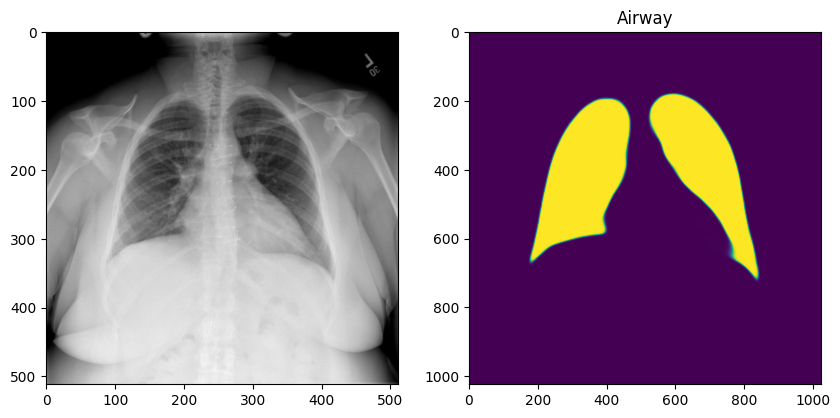

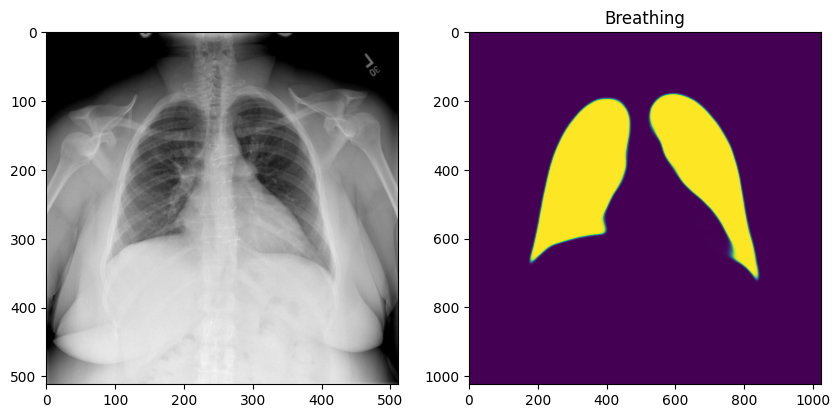

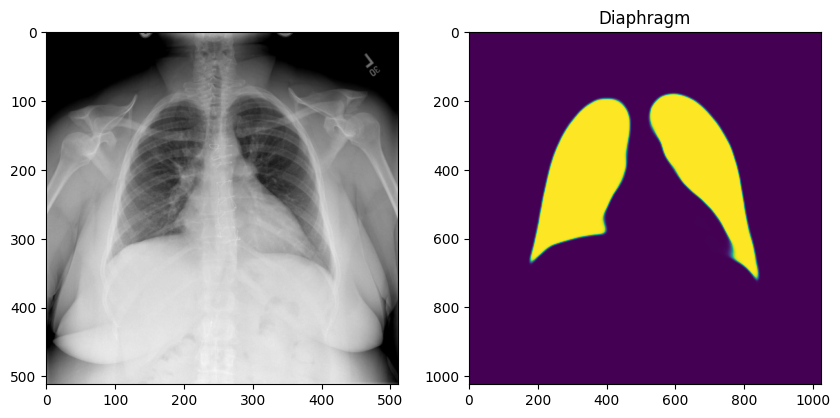

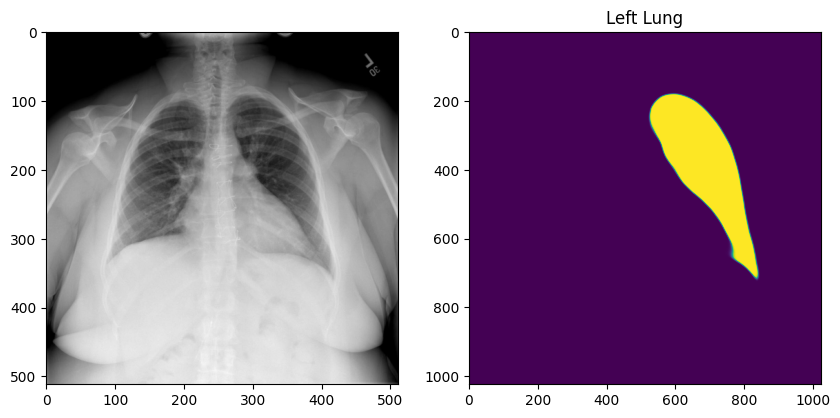

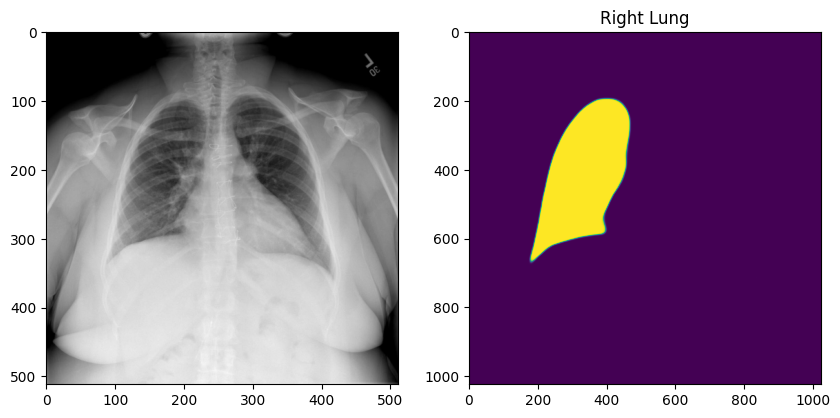

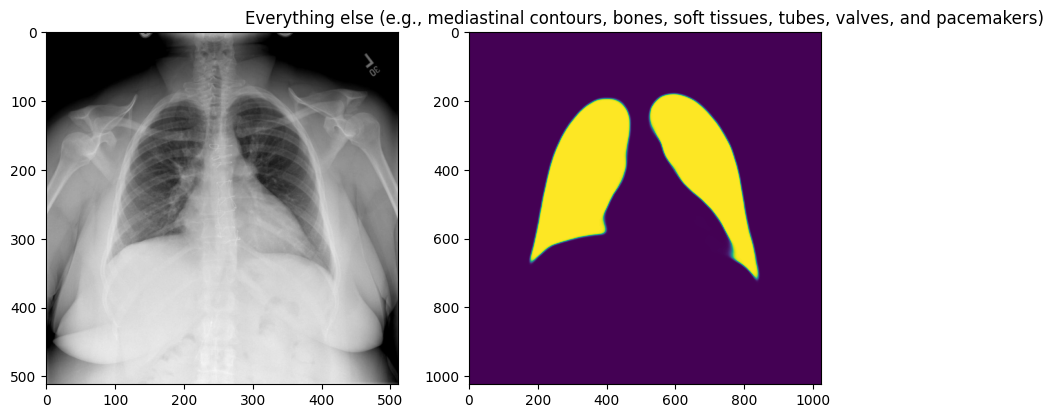

4.png
{'FINDINGS': 'There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion.', 'IMPRESSION': '1. Bullous emphysema and interstitial fibrosis. 2. Probably scarring in the left apex, although difficult to exclude a cavitary lesion. 3. Opacities in the bilateral upper lobes could represent scarring, however the absence of comparison exam, recommend short interval followup radiograph or CT thorax to document resolution.'}


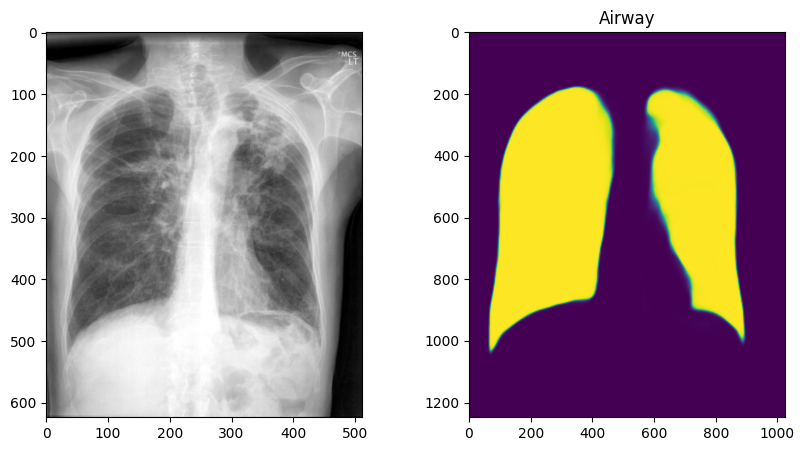

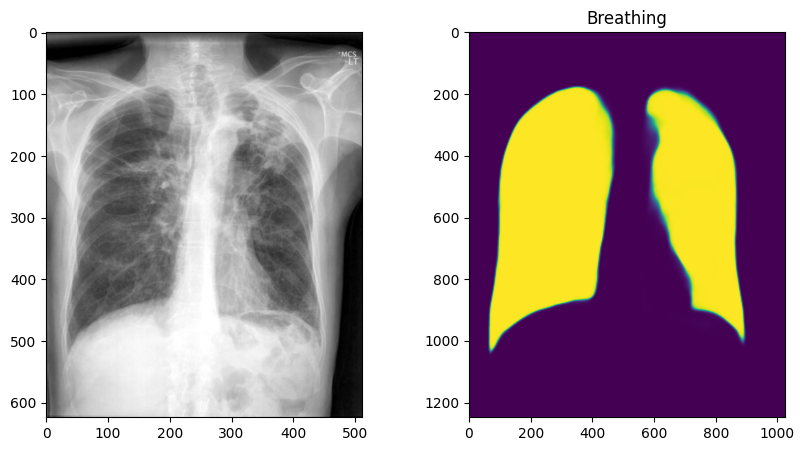

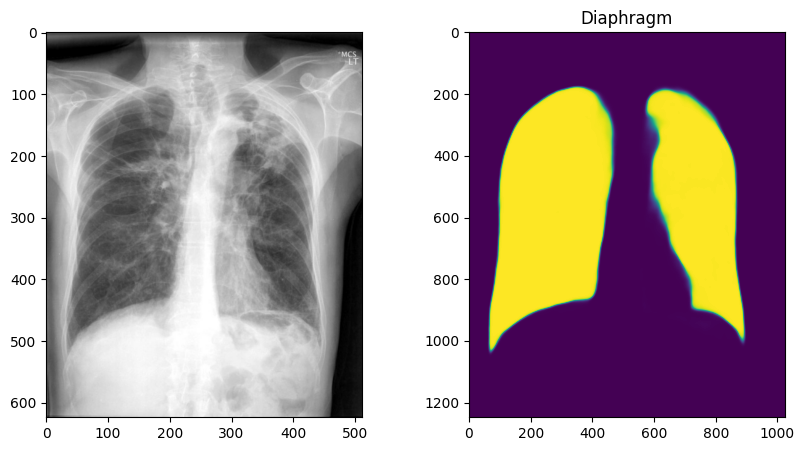

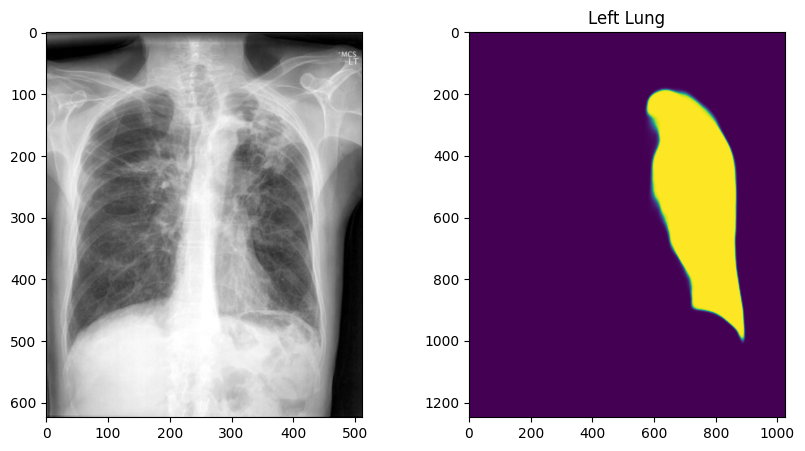

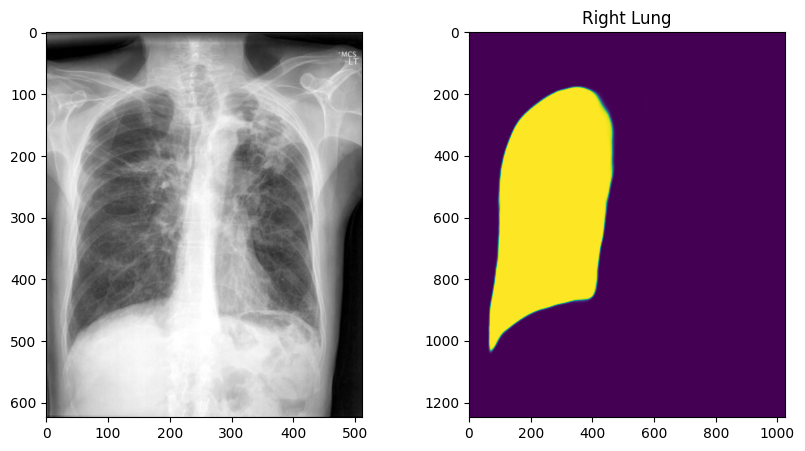

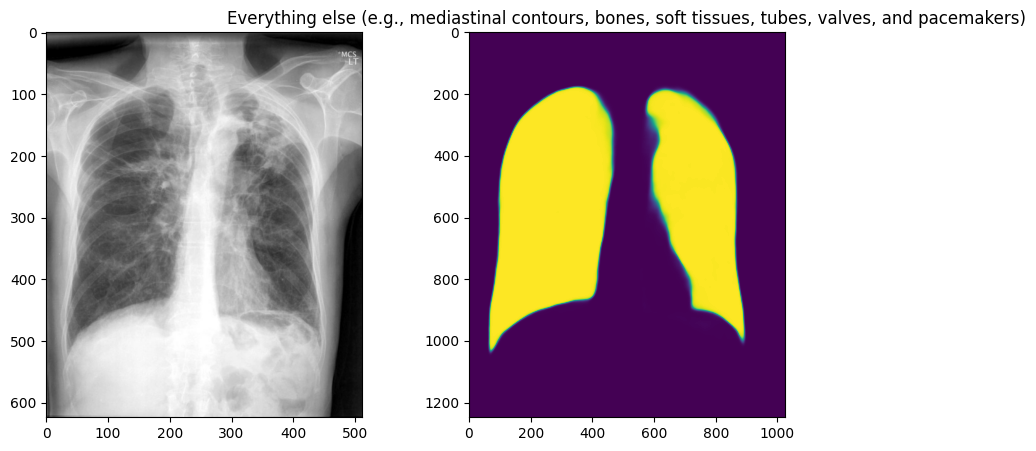

6.png
{'FINDINGS': 'Heart size and mediastinal contour are within normal limits. There is no focal airspace consolidation or suspicious pulmonary opacity. No pneumothorax or large pleural effusion. Mild degenerative change of the thoracic spine.', 'IMPRESSION': 'No acute cardiopulmonary findings.'}


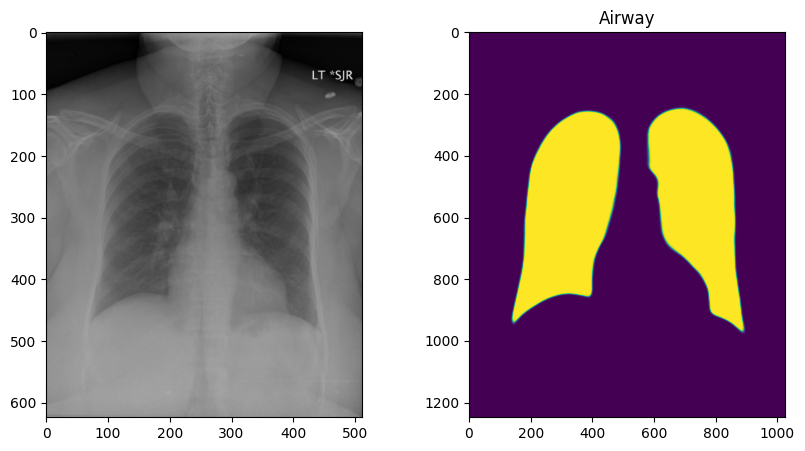

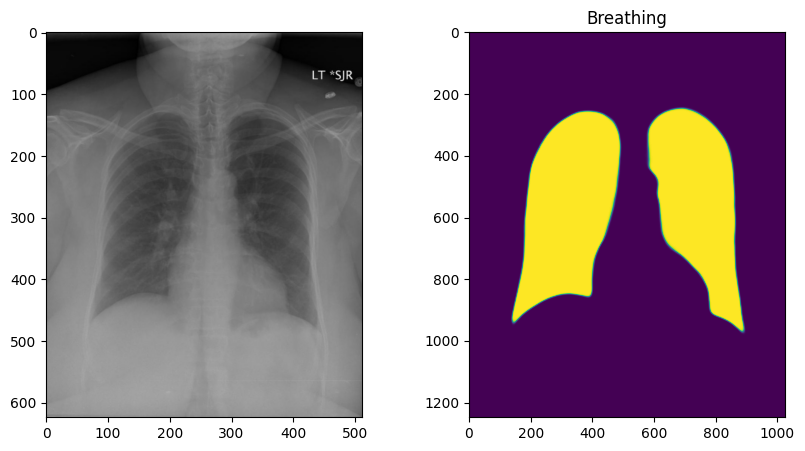

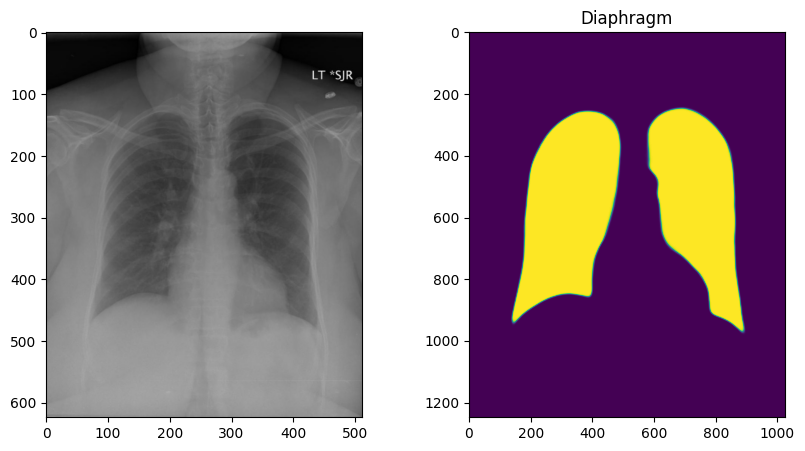

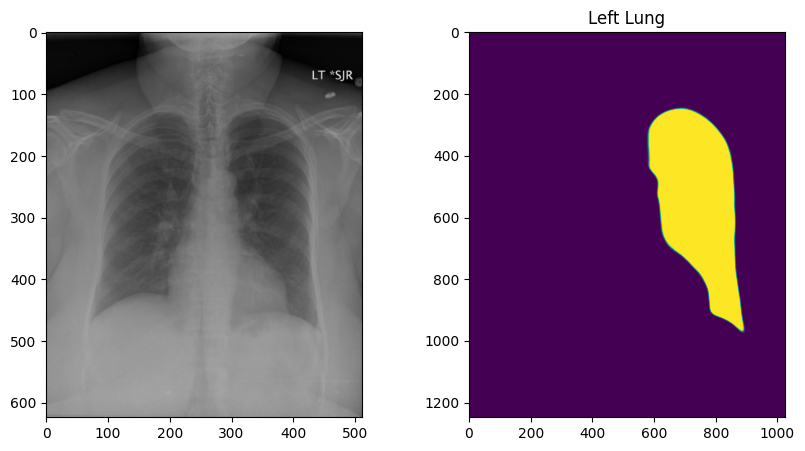

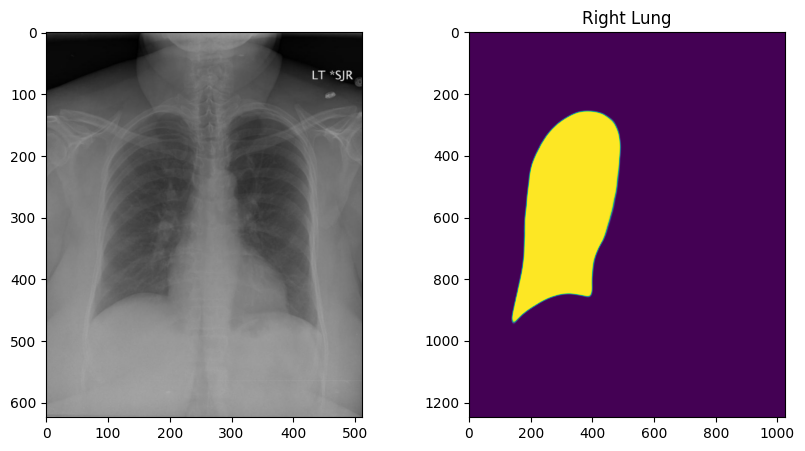

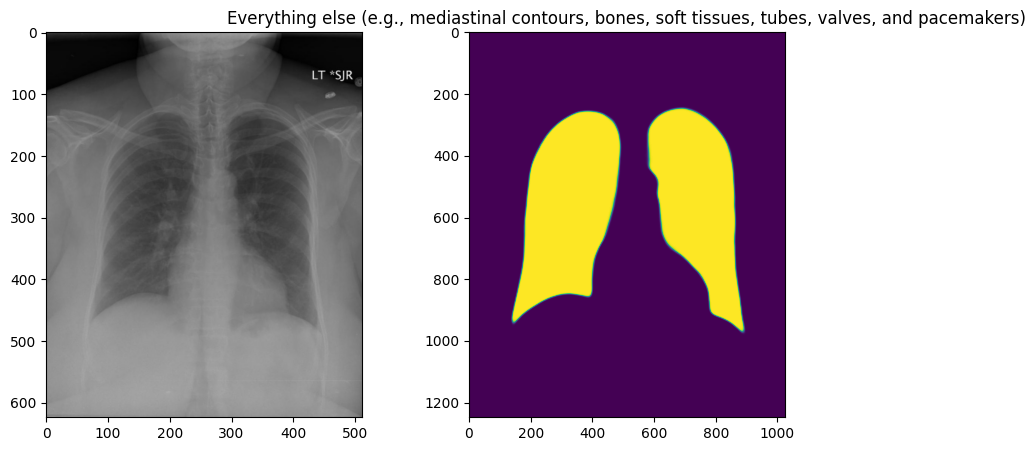

7.png
{'FINDINGS': 'The cardiac contours are normal. XXXX basilar atelectasis. The lungs are clear. Thoracic spondylosis. Lower cervical XXXX arthritis.', 'IMPRESSION': 'Basilar atelectasis. No confluent lobar consolidation or pleural effusion.'}


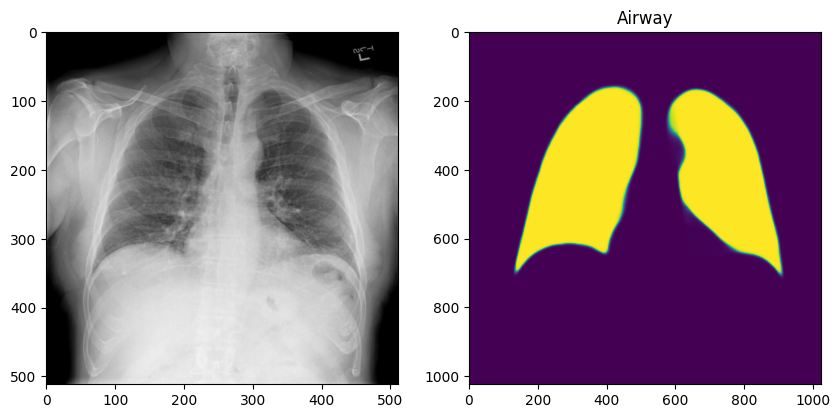

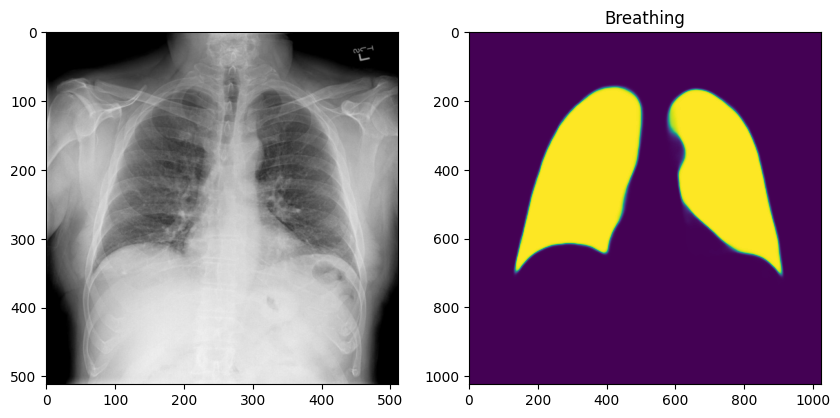

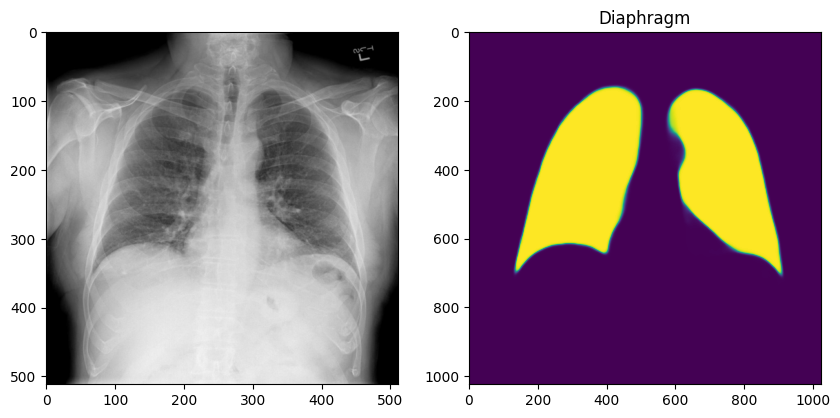

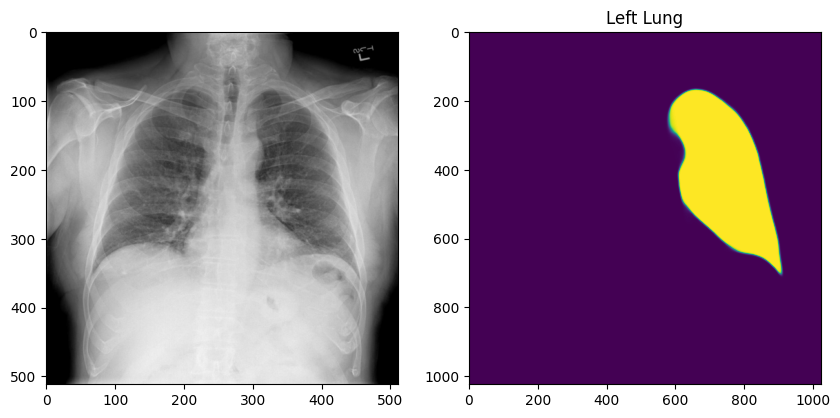

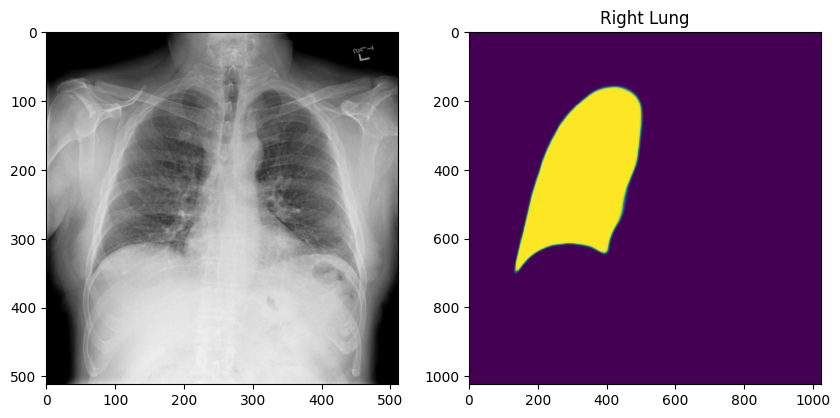

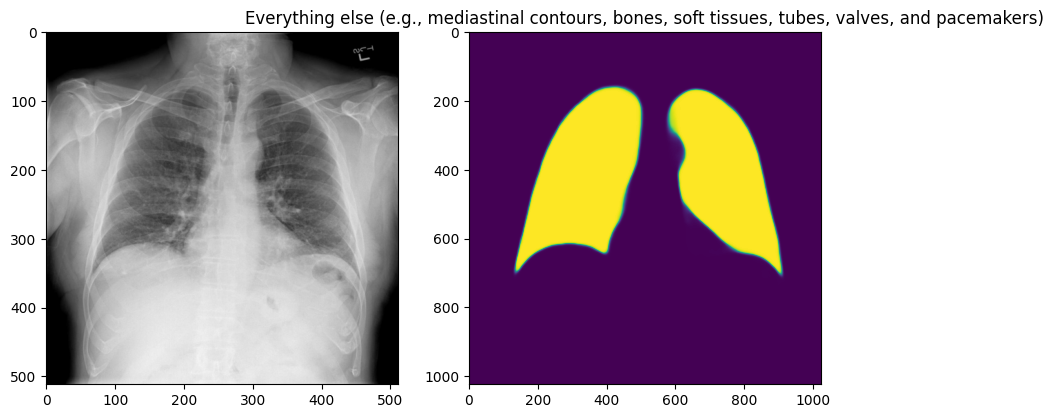

8.png
{'FINDINGS': 'The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is an interim XXXX cervical spinal fusion partly evaluated.', 'IMPRESSION': 'No acute cardiopulmonary disease.'}


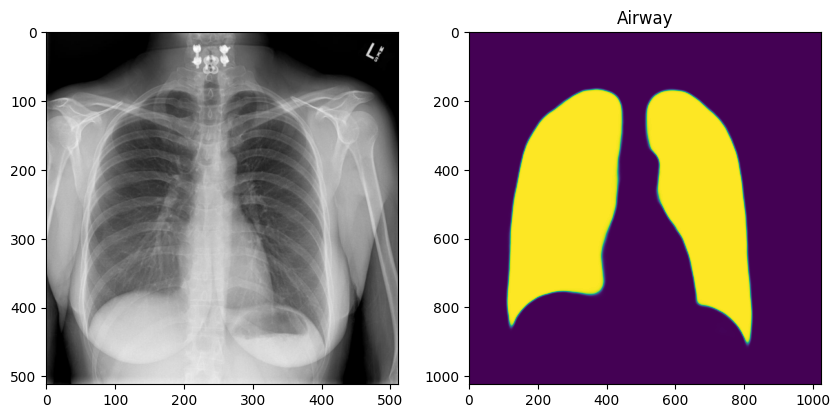

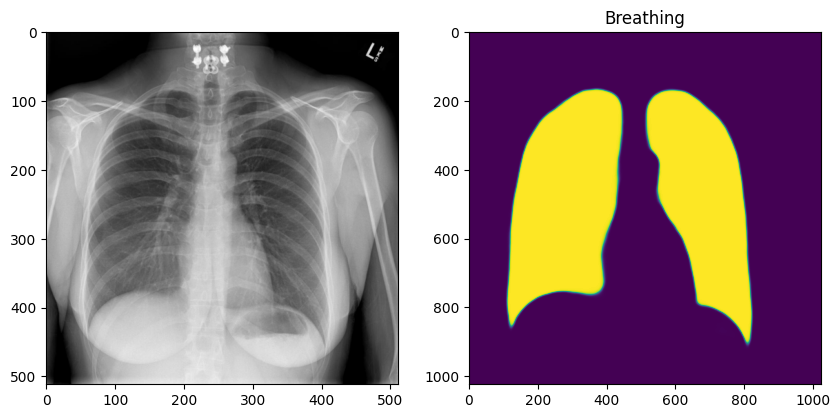

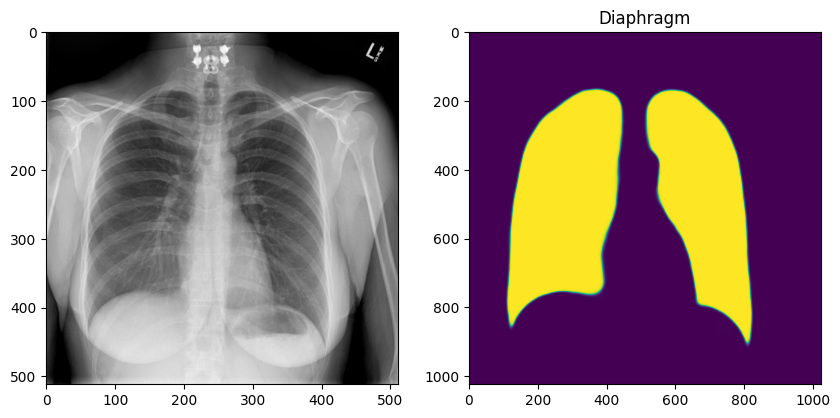

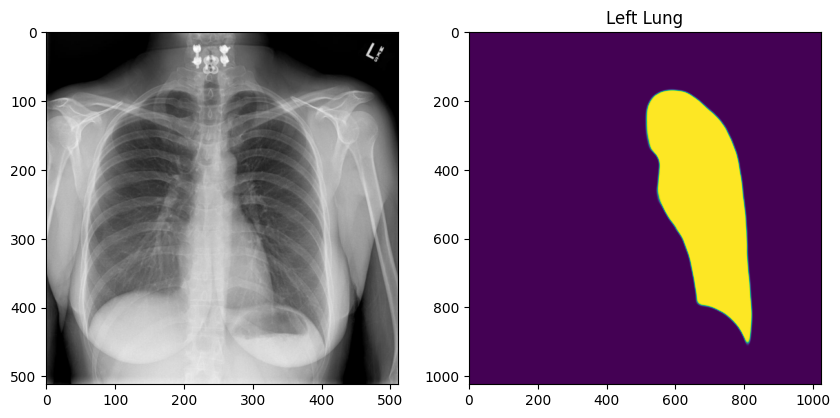

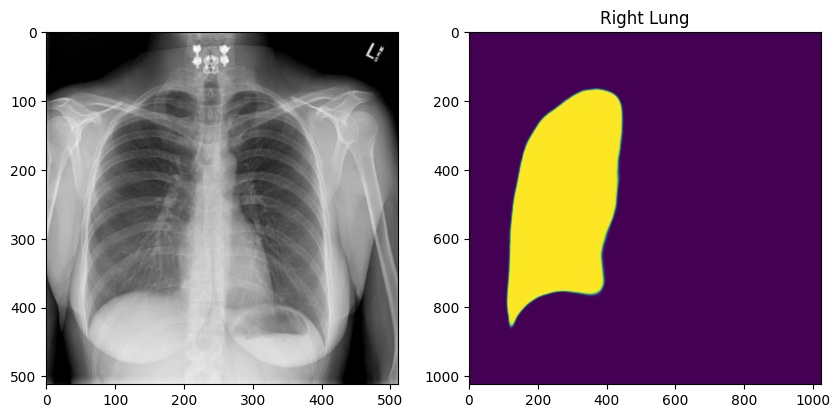

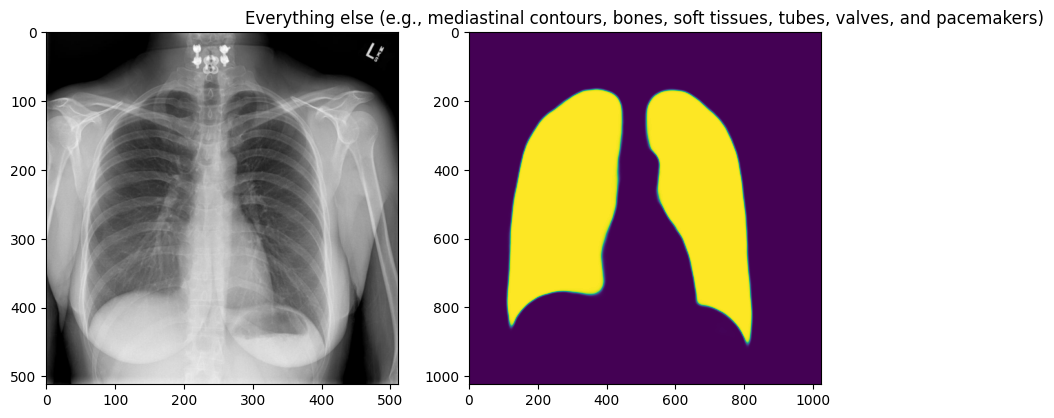

9.png
{'FINDINGS': 'The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiac silhouette is not enlarged. There has been apparent interval increase in low density convexity at the left cardiophrenic XXXX. Calcified granuloma is again seen in the right upper lobe. There is no consolidation, pleural effusion or pneumothorax.', 'IMPRESSION': 'Increased size of density in the left cardiophrenic XXXX. Primary differential considerations include increased size of prominent epicardial fat, pericardial mass, pleural mass or cardiac aneurysm. CT chest with contrast is recommended. These findings and recommendations were discussed XXXX. XXXX by Dr. XXXX XXXX telephone at XXXX p.m. XXXX/XXXX. Dr. XXXX<XXXX>technologist receipt of the results.'}


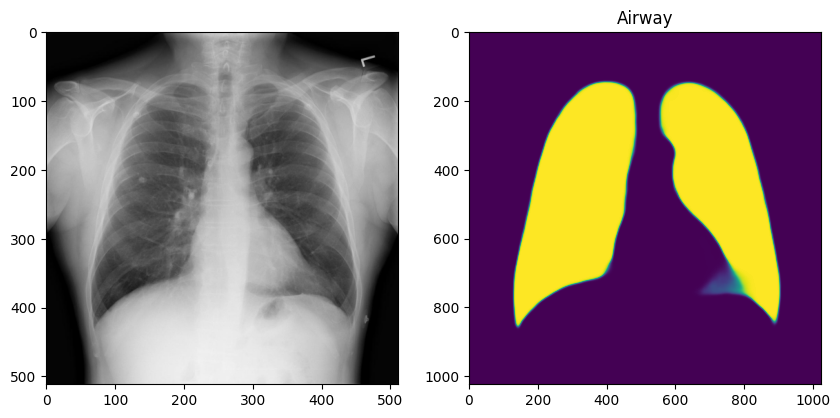

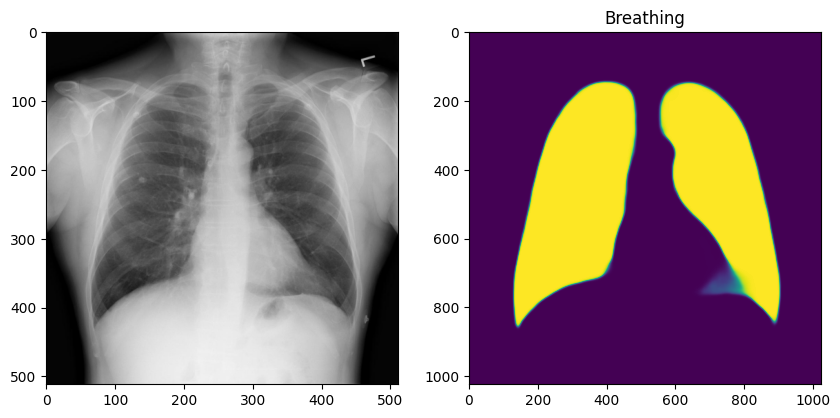

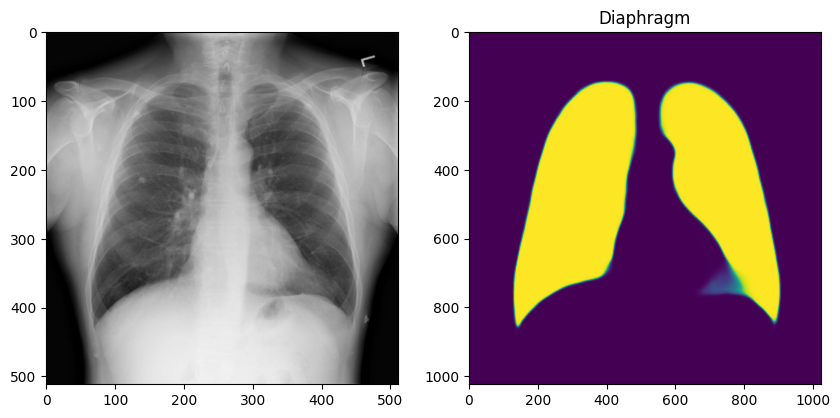

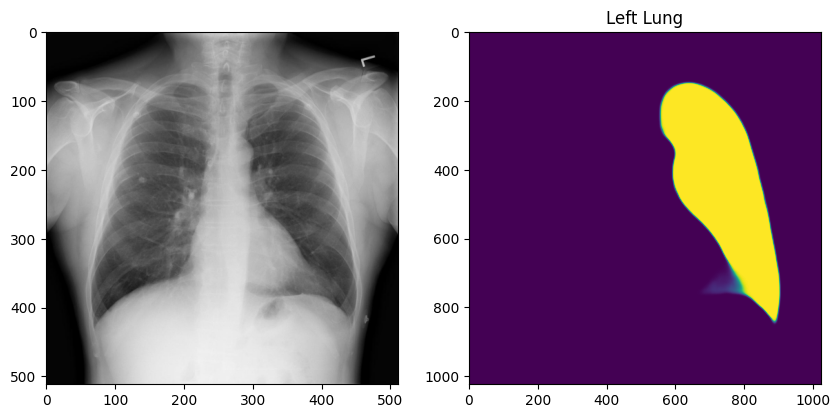

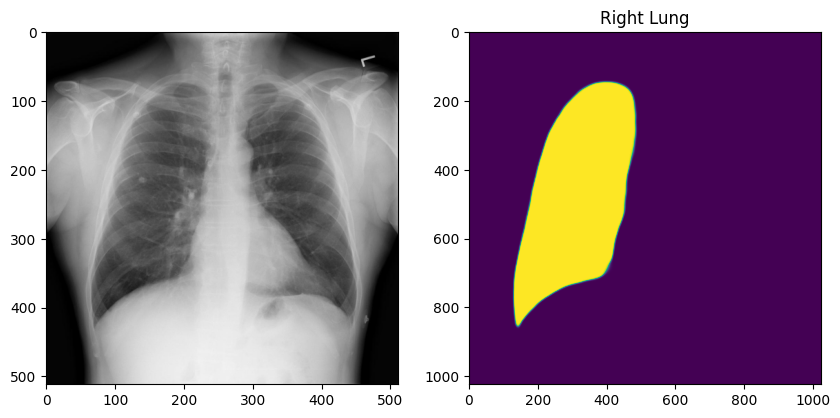

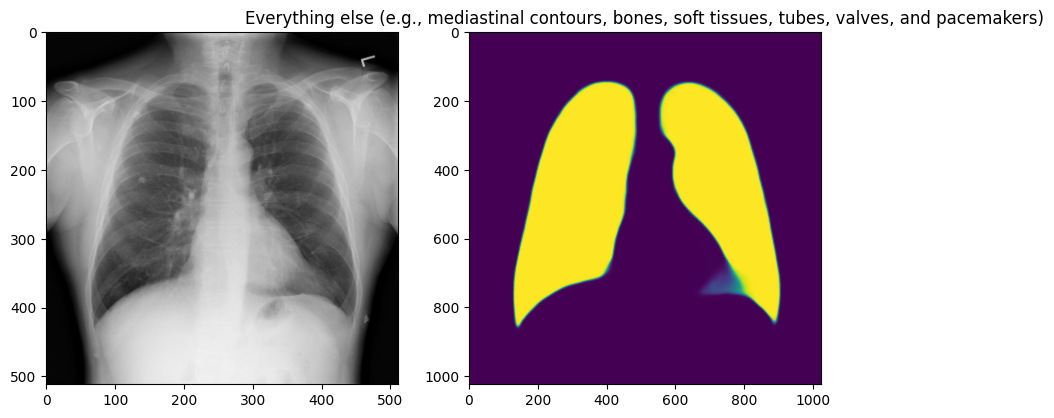

In [ ]:
all_gt = []
all_model = []
baseline_model = []
image_selector = Image_Selector(None)
for i in range(10):
  if os.path.exists(f"{i}.png"):

    prompts_for_image_selector = ["Airway", "Breathing", "Diaphragm", "Left Lung", "Right Lung", "Everything else (e.g., mediastinal contours, bones, soft tissues, tubes, valves, and pacemakers)"]


    image_path = f"{i}.png"
    print(image_path)
    abstract = parse_radiology_gt(f"{i}.xml")
    print(abstract)

    image_selector.upload_image(image_path)
    pred_mask = image_selector.infer_image(prompts_for_image_selector)
    for i, mask in enumerate(pred_mask):
      image_selector.show_image_and_pred(mask, prompts_for_image_selector[i])



## Some exploration of biomedparse model (Can ignore)

In [ ]:
from PIL import Image
import torch
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image
import numpy as np

# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
#pretrained_pth = 'pretrained/biomed_parse.pt'
pretrained_pth = 'hf_hub:microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)


Deformable Transformer Encoder is not available.


/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

/content/BiomedParse/modeling/BaseModel.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_dir, map_location=self.opt['device'])


In [ ]:
from PIL import Image, ImageEnhance, ImageOps
# RGB image input of shape (H, W, 3). Currently only batch size 1 is supported.
# image = Image.open('examples/Part_1_516_pathology_breast.png', formats=['png'])
image = Image.open('CXR4_IM-2050-1001.png', formats=['png'])
image = image.convert('RGB')
image_colorized = ImageOps.colorize(ImageOps.grayscale(image), black="blue", white="orange")

# text prompts querying objects in the image. Multiple ones can be provided.
prompts = ['lung opacity']

# load ground truth mask
gt_masks = []
# for prompt in prompts:
#     gt_mask = Image.open(f"examples/Part_1_516_pathology_breast_{prompt.replace(' ', '+')}.png", formats=['png'])
#     gt_mask = 1*(np.array(gt_mask.convert('RGB'))[:,:,0] > 0)
#     gt_masks.append(gt_mask)

pred_mask = interactive_infer_image(model, image_colorized, prompts)

# prediction with ground truth mask
# for i, pred in enumerate(pred_mask):
#     gt = gt_masks[i]
#     dice = (1*(pred>0.5) & gt).sum() * 2.0 / (1*(pred>0.5).sum() + gt.sum())
#     print(f'Dice score for {prompts[i]}: {dice:.4f}')

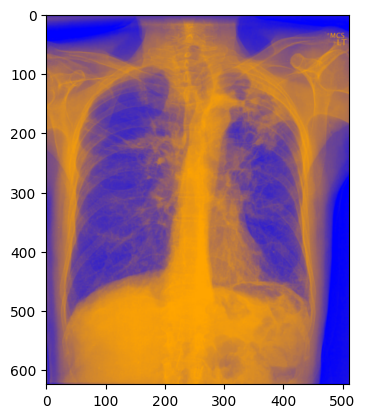

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(image_colorized)
# plt.imshow(pred_mask[0])

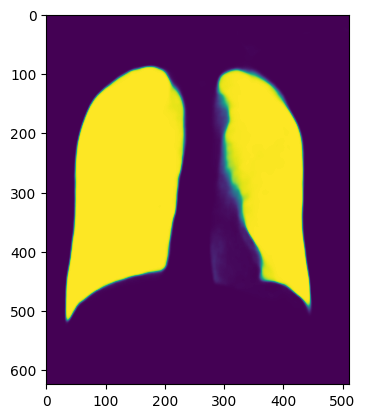

In [ ]:
plt.imshow(pred_mask[0])

In [ ]:
pred_mask[0]

array([[2.89941872e-05, 7.89043588e-06, 5.84340000e-07, ...,
        1.58424643e-06, 5.25632277e-06, 9.57437442e-06],
       [2.21337941e-05, 5.50246114e-06, 3.40052623e-07, ...,
        1.10081510e-06, 4.63376637e-06, 9.50697176e-06],
       [8.47508545e-06, 1.52740154e-06, 4.96095645e-08, ...,
        3.01682547e-07, 2.95988229e-06, 9.27115252e-06],
       ...,
       [7.10377299e-06, 4.14478382e-06, 1.41099599e-06, ...,
        5.97243366e-09, 1.52544806e-06, 2.43787399e-05],
       [1.99579099e-05, 1.04968576e-05, 2.90363232e-06, ...,
        3.23832268e-07, 1.65865349e-05, 1.18695134e-04],
       [2.66867228e-05, 1.36321250e-05, 3.55708039e-06, ...,
        9.95577921e-07, 3.24517787e-05, 1.85251003e-04]], dtype=float32)

In [ ]:
# RGB image input of shape (H, W, 3). Currently only batch size 1 is supported.
image = Image.open('examples/Part_1_516_pathology_breast.png', formats=['png'])
image = image.convert('RGB')
# text prompts querying objects in the image. Multiple ones can be provided.
prompts = ['neoplastic cells', 'inflammatory cells']

# load ground truth mask
gt_masks = []
for prompt in prompts:
    gt_mask = Image.open(f"examples/Part_1_516_pathology_breast_{prompt.replace(' ', '+')}.png", formats=['png'])
    gt_mask = 1*(np.array(gt_mask.convert('RGB'))[:,:,0] > 0)
    gt_masks.append(gt_mask)

pred_mask = interactive_infer_image(model, image, prompts)

# prediction with ground truth mask
for i, pred in enumerate(pred_mask):
    gt = gt_masks[i]
    dice = (1*(pred>0.5) & gt).sum() * 2.0 / (1*(pred>0.5).sum() + gt.sum())
    print(f'Dice score for {prompts[i]}: {dice:.4f}')